In [1]:
#importing libraries
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve

from sklearn.calibration import calibration_curve
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

#importing Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

In [2]:
from sklearn.metrics import confusion_matrix

def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Stroke','No Stroke']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),
                     horizontalalignment='center', color='White')

    plt.show()
print('plot_cm defined')

plot_cm defined


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load data
df = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')

In [5]:
df.head()


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

In [8]:
#Data cleaning
#Removing Unnecessary columns
df.drop(['id'],axis=1,inplace = True)

In [9]:
#Null Values Counting
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
# Null Value Dropping

#df.dropna(inplace=True)

#df.isnull().sum().sum()

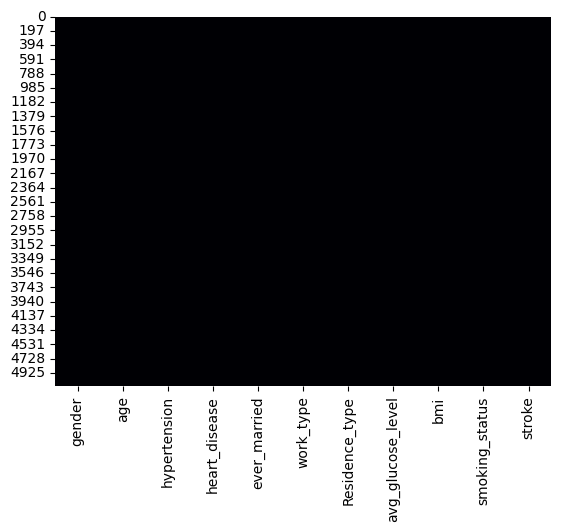

In [11]:
df['bmi'].fillna(df['bmi'].mean(),inplace = True)
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False);

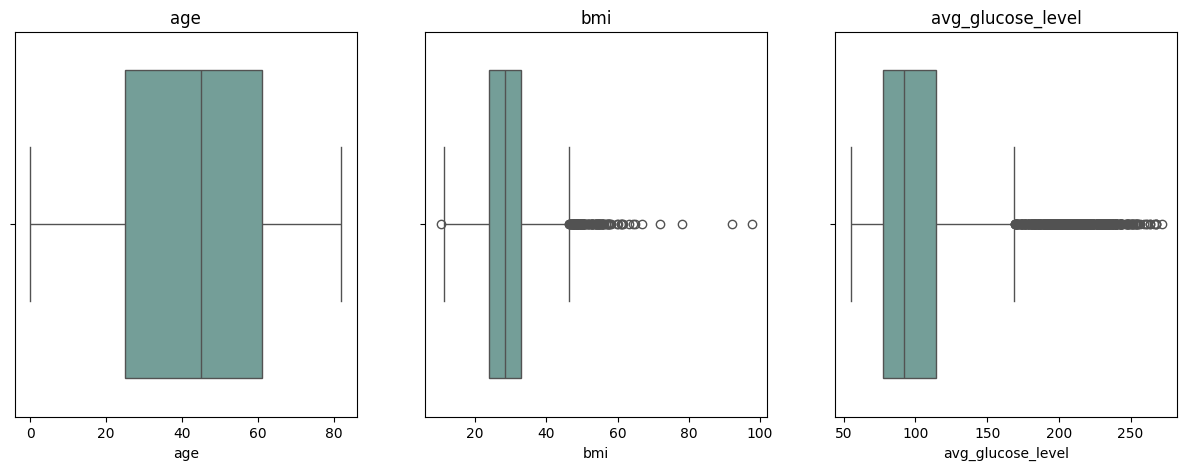

In [12]:
num_cols = ['age','bmi','avg_glucose_level']

plt.figure(figsize=(15, 5))
for i in range(3) :
    plt.subplot(1,3,i+1)

    sns.boxplot(x=df[num_cols[i]],color='#6DA59D')
    plt.title(num_cols[i])
plt.show()

In [13]:
#Outliers Detection
def detect_outliers(data,column):
    q1 = df[column].quantile(.25)
    q3= df[column].quantile(.75)
    IQR = q3-q1

    lower_bound = q1 - (1.5*IQR)
    upper_bound = q3 + (1.5*IQR)

    ls = df.index[(df[column] <lower_bound) | (df[column] > upper_bound)]

    return ls

In [14]:
#Outlier Removing
index_list = []

for column in num_cols:
    index_list.extend(detect_outliers(df,column))

# remove duplicated indices in the index_list and sort it
index_list = sorted(set(index_list))

In [15]:
#649 outliers removed
before_remove = df.shape

df =df.drop(index_list)
after_remove = df.shape

print(f'''Shape of data before removing outliers : {before_remove}
Shape of data after remove : {after_remove}''')

Shape of data before removing outliers : (5110, 11)
Shape of data after remove : (4391, 11)


<ipython-input-16-054969c77220>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['gender'],palette='bone')


Text(0.5, 0, 'Gender')

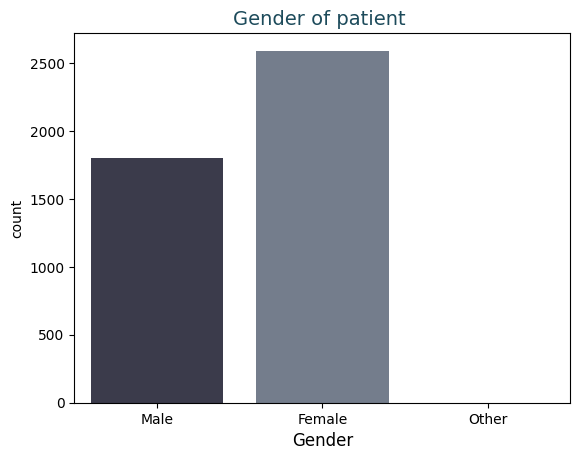

In [16]:
#Data Visualization
sns.countplot(x=df['gender'],palette='bone')
plt.title('Gender of patient ' , size = 14,color = '#1D4B5B')
plt.xlabel('Gender',size = 12)

In [17]:
#Data Visualization
import plotly.express as px
married = dict(df['ever_married'].value_counts())
fig = px.pie(names = married.keys(),values = married.values(),title = 'Ever Married',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [18]:
h_disease = dict(df['heart_disease'].value_counts())
fig = px.pie(names = ['False' , 'True'],values = h_disease.values(),title = 'Had a Heart Disease ',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [19]:
hypertension = dict(df['hypertension'].value_counts())
fig = px.pie(names =['False','True'],values = hypertension.values(),title = 'Had a Hypertension',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [20]:
work_types = dict(df['work_type'].value_counts())
fig = px.pie(names = work_types.keys(),values = work_types.values(),title = 'Work Type',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [21]:
Residence_types = dict(df['Residence_type'].value_counts())
fig = px.pie(names = Residence_types.keys(),values = Residence_types.values(),title = 'Residence type',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

In [22]:
smoking_status = dict(df['smoking_status'].value_counts())

fig = px.pie(names = smoking_status.keys(),values = smoking_status.values(),title = 'Smoking Status',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')

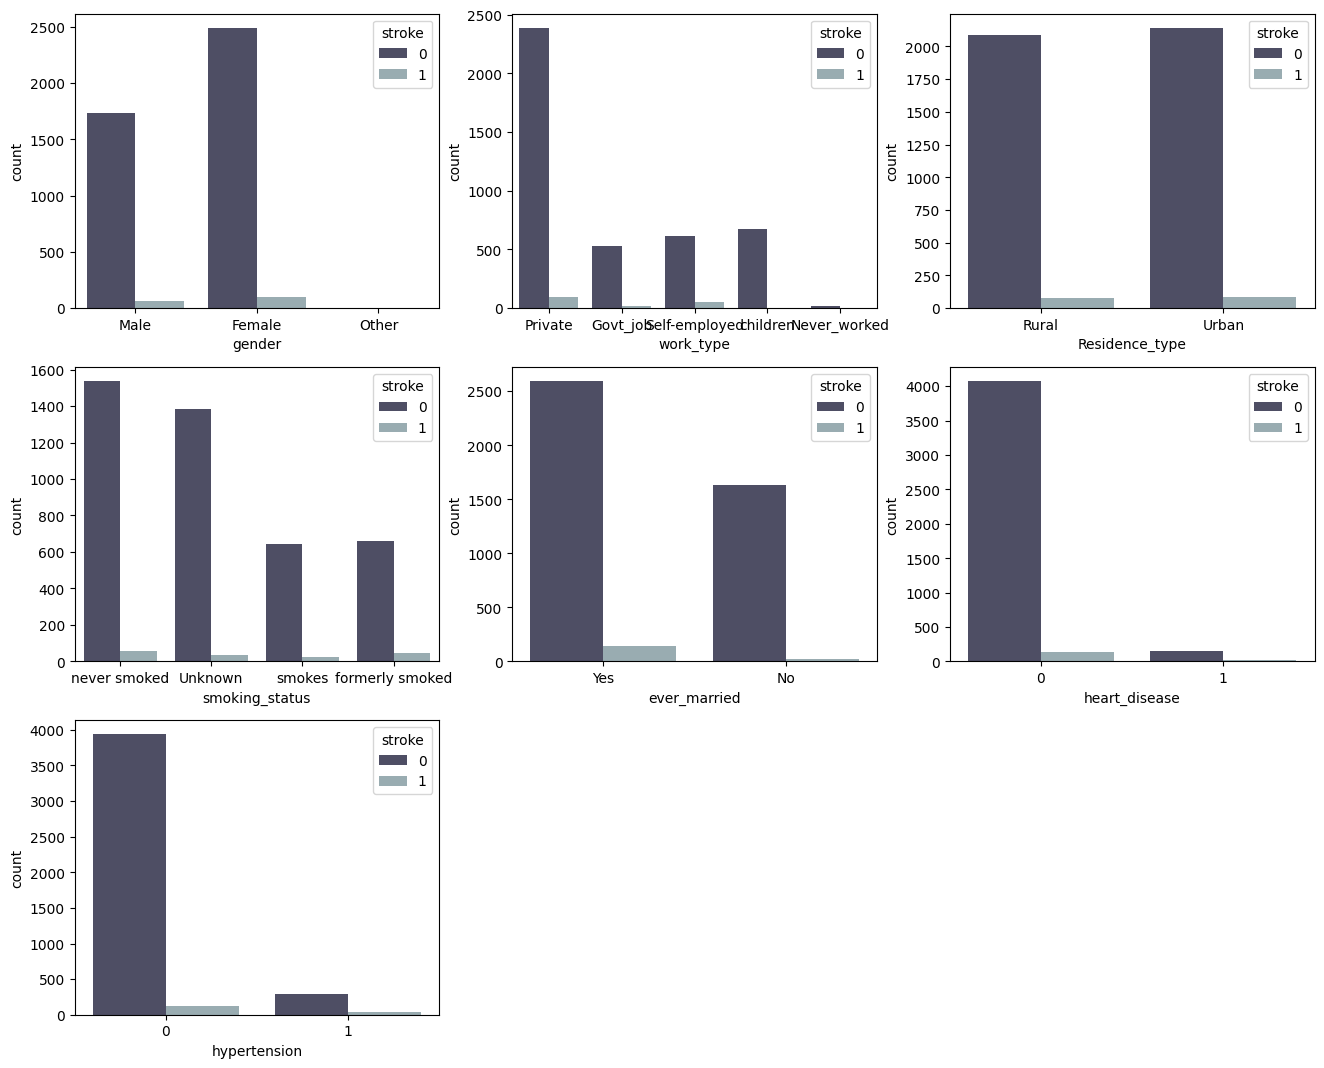

In [23]:
cols = ['gender','work_type','Residence_type','smoking_status','ever_married','heart_disease','hypertension']
plt.figure(figsize=(16,13))
for i in range(len(cols)):
    plt.subplot(3,3,i+1)

    sns.countplot(x=df[cols[i]],hue = df['stroke'],palette = 'bone')

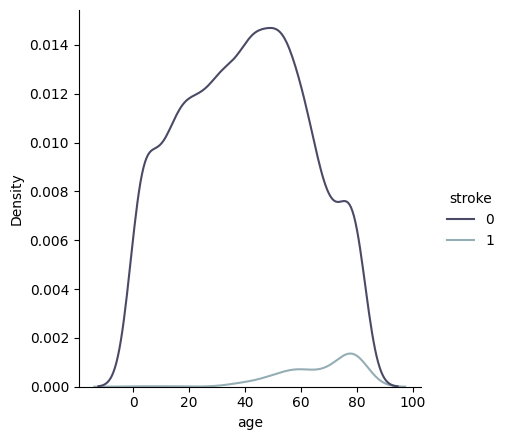

In [24]:
sns.displot(data = df , x='age',hue = 'stroke',kind = 'kde',palette = 'bone',height=4.5 )
plt.show()


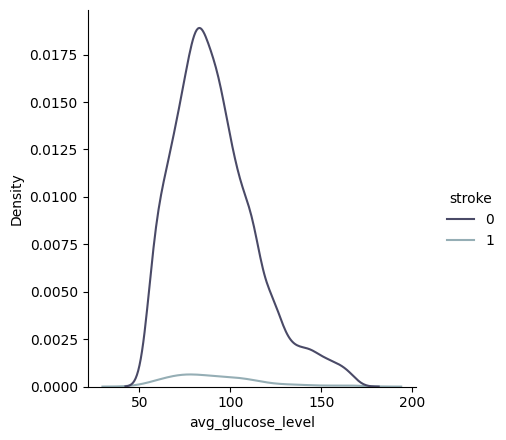

In [25]:
sns.displot(data = df , x='avg_glucose_level',hue = 'stroke',kind = 'kde',palette = 'bone',height=4.5 )
plt.show()

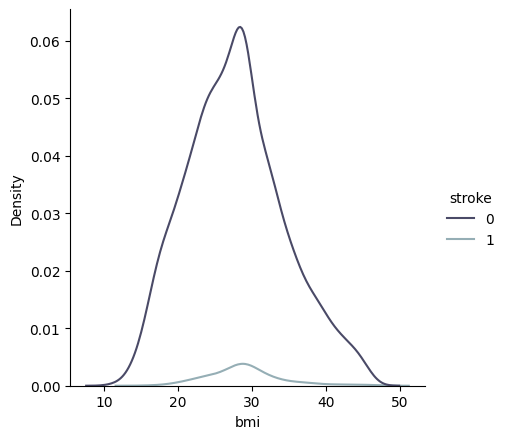

In [26]:
sns.displot(data = df , x='bmi',hue = 'stroke',kind = 'kde',palette = 'bone',height=4.5 )
plt.show()

In [27]:
stroke = dict(df['stroke'].value_counts())

fig = px.pie(names = stroke.keys(),values = stroke.values(),title = 'Stroke Occurance',color_discrete_sequence=px.colors.sequential.Aggrnyl)
fig.update_traces(textposition='inside', textinfo='percent+label')
#Unbalanced data.Need for balancing

In [28]:
#Resamble Unbalanced Data
df_0 = df[df.iloc[:,-1]==0]
df_1 = df[df.iloc[:,-1]==1]

df['stroke'].value_counts()

0    4226
1     165
Name: stroke, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
#Data preprocessing
#Resample Unbalanced Data
#from sklearn.utils import resample

#df_1 = resample(df_1,replace=True , n_samples=df_0.shape[0] , random_state=123 )

In [31]:
#concatenate upsampled data
#df = np.concatenate((df_0,df_1))

#create the balanced dataframe
#df = pd.DataFrame(df)
#df.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']

# visualize balanced data
#stroke = dict(df['stroke'].value_counts())
#fig = px.pie(names = ['False','True'],values = stroke.values(),title = 'Stroke Occurance',color_discrete_sequence=px.colors.sequential.Aggrnyl)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#Data Balanced

In [32]:
#Data Encoding
#df = pd.get_dummies(data =df , columns =  ['gender','ever_married','work_type','Residence_type','smoking_status'] ,drop_first=True )

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [34]:
le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    df[i] = le.fit_transform(df[i])
    l3.append(list(df[i].unique())); l4.append(list(le.inverse_transform(df[i].unique())))
    print(i,' : ',df[i].unique(),' = ',le.inverse_transform(df[i].unique()))

Label Encoder Transformation


100%|██████████| 5/5 [00:00<00:00, 186.45it/s]

gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 0 3 4 1]  =  ['Private' 'Govt_job' 'Self-employed' 'children' 'Never_worked']
Residence_type  :  [0 1]  =  ['Rural' 'Urban']
smoking_status  :  [2 0 3 1]  =  ['never smoked' 'Unknown' 'smokes' 'formerly smoked']


In [35]:
tf1 = {}
for i in range(len(text_data_features)):
    tf1[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_data_features[i]][j] = k

tf1['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'}
tf1['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
tf1

{'gender': {1: 'Male', 0: 'Female', 2: 'Other'},
 'ever_married': {1: 'Yes', 0: 'No'},
 'work_type': {2: 'Private',
  0: 'Govt_job',
  3: 'Self-employed',
  4: 'children',
  1: 'Never_worked'},
 'Residence_type': {0: 'Rural', 1: 'Urban'},
 'smoking_status': {2: 'never smoked',
  0: 'Unknown',
  3: 'smokes',
  1: 'formerly smoked'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

In [36]:
df.head()

gender   age  hypertension  heart_disease  ever_married  work_type  \
2       1 80.00             0              1             1          2   
6       1 74.00             1              1             1          2   
7       0 69.00             0              0             0          2   
8       0 59.00             0              0             1          2   
9       0 78.00             0              0             1          2   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
2               0             105.92 32.50               2       1  
6               0              70.09 27.40               2       1  
7               1              94.39 22.80               2       1  
8               0              76.15 28.89               0       1  
9               1              58.57 24.20               0       1

In [37]:
f1 = df.loc[:,:'smoking_status']
t1 = df.loc[:,'stroke']

In [38]:
f1

gender   age  hypertension  heart_disease  ever_married  work_type  \
2          1 80.00             0              1             1          2   
6          1 74.00             1              1             1          2   
7          0 69.00             0              0             0          2   
8          0 59.00             0              0             1          2   
9          0 78.00             0              0             1          2   
...      ...   ...           ...            ...           ...        ...   
5105       0 80.00             1              0             1          2   
5106       0 81.00             0              0             1          3   
5107       0 35.00             0              0             1          3   
5108       1 51.00             0              0             1          2   
5109       0 44.00             0              0             1          0   

      Residence_type  avg_glucose_level   bmi  smoking_status  
2                  0             105.92 32.50               2  
6                  0              70.09 27.40               2  
7                  1              94.39 22.80               2  
8                  0              76.15 28.89               0  
9                  1              58.57 24.20               0  
...              ...                ...   ...             ...  
5105               1              83.75 28.89               2  
5106               1             125.20 40.00               2  
5107               0              82.99 30.60               2  
5108               0             166.29 25.60               1  
5109               1              85.28 26.20               0  

[4391 rows x 10 columns]

In [39]:
t1

2       1
6       1
7       1
8       1
9       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 4391, dtype: int64

In [40]:
#Data Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

f1 = scaler.fit_transform(f1)

In [41]:
f1

array([[ 1.19751307,  1.73471616, -0.2831904 , ...,  0.6373796 ,
         0.71456272,  0.60326156],
       [ 1.19751307,  1.46854377,  3.53119316, ..., -0.94383043,
        -0.06269896,  0.60326156],
       [-0.833495  ,  1.24673345, -0.2831904 , ...,  0.12855036,
        -0.76375852,  0.60326156],
       ...,
       [-0.833495  , -0.26157676, -0.2831904 , ..., -0.37454186,
         0.42499464,  0.60326156],
       [ 1.19751307,  0.44821628, -0.2831904 , ...,  3.30156182,
        -0.33702662, -0.31842303],
       [-0.833495  ,  0.13768183, -0.2831904 , ..., -0.27348211,
        -0.24558407, -1.24010762]])

In [42]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(f1, t1)
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.20, random_state=42)

In [43]:
x_smote

array([[ 1.19751307,  1.73471616, -0.2831904 , ...,  0.6373796 ,
         0.71456272,  0.60326156],
       [ 1.19751307,  1.46854377,  3.53119316, ..., -0.94383043,
        -0.06269896,  0.60326156],
       [-0.833495  ,  1.24673345, -0.2831904 , ...,  0.12855036,
        -0.76375852,  0.60326156],
       ...,
       [-0.833495  , -0.03354535, -0.2831904 , ...,  0.13652048,
         0.30238066,  1.37481239],
       [-0.833495  ,  1.46750602,  3.53119316, ...,  0.77387804,
         0.73122922,  0.20517376],
       [-0.833495  ,  1.72435814, -0.2831904 , ..., -0.32549906,
        -0.7676289 ,  0.60326156]])

In [44]:
Counter(y_smote)

Counter({1: 4226, 0: 4226})

In [45]:
x_train

array([[-0.833495  , -0.03249446, -0.2831904 , ..., -0.38657458,
        -0.53840642, -0.37090868],
       [-0.833495  ,  1.42418171,  3.53119316, ..., -1.3458629 ,
         0.31831167, -0.31842303],
       [ 1.19751307,  0.6700266 , -0.2831904 , ..., -0.39881386,
         1.01937123,  0.60326156],
       ...,
       [-0.833495  ,  1.77156703,  3.53119316, ..., -0.59511449,
         0.43491603,  0.60326156],
       [-0.833495  , -0.43902502, -0.2831904 , ..., -1.14771517,
         0.04398401,  0.60326156],
       [-0.833495  ,  0.52069992, -0.2831904 , ...,  0.30496754,
        -0.25098717,  0.68672806]])

In [46]:
#Data Splitting
x = df.drop('stroke', axis = 1)
y = pd.to_numeric( df['stroke'])

In [47]:
x

gender   age  hypertension  heart_disease  ever_married  work_type  \
2          1 80.00             0              1             1          2   
6          1 74.00             1              1             1          2   
7          0 69.00             0              0             0          2   
8          0 59.00             0              0             1          2   
9          0 78.00             0              0             1          2   
...      ...   ...           ...            ...           ...        ...   
5105       0 80.00             1              0             1          2   
5106       0 81.00             0              0             1          3   
5107       0 35.00             0              0             1          3   
5108       1 51.00             0              0             1          2   
5109       0 44.00             0              0             1          0   

      Residence_type  avg_glucose_level   bmi  smoking_status  
2                  0             105.92 32.50               2  
6                  0              70.09 27.40               2  
7                  1              94.39 22.80               2  
8                  0              76.15 28.89               0  
9                  1              58.57 24.20               0  
...              ...                ...   ...             ...  
5105               1              83.75 28.89               2  
5106               1             125.20 40.00               2  
5107               0              82.99 30.60               2  
5108               0             166.29 25.60               1  
5109               1              85.28 26.20               0  

[4391 rows x 10 columns]

In [48]:
y

2       1
6       1
7       1
8       1
9       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 4391, dtype: int64

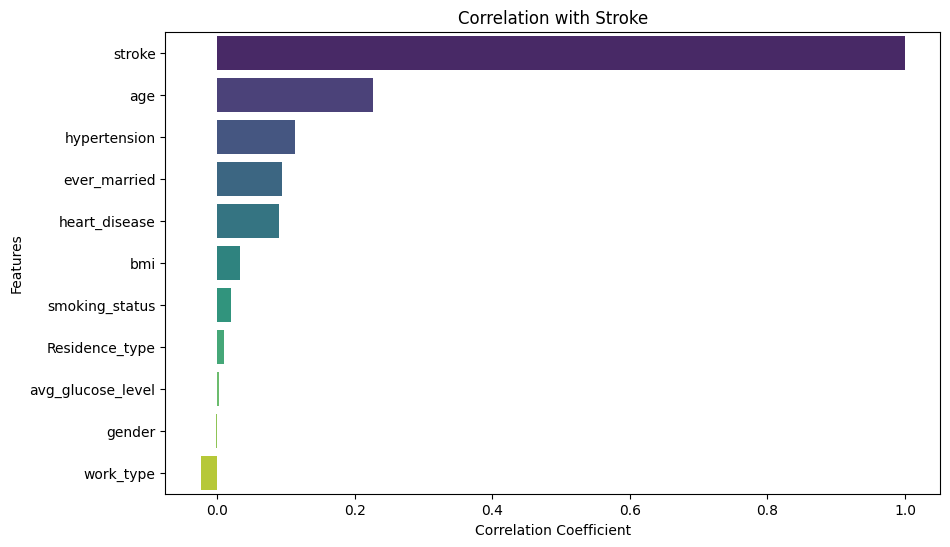

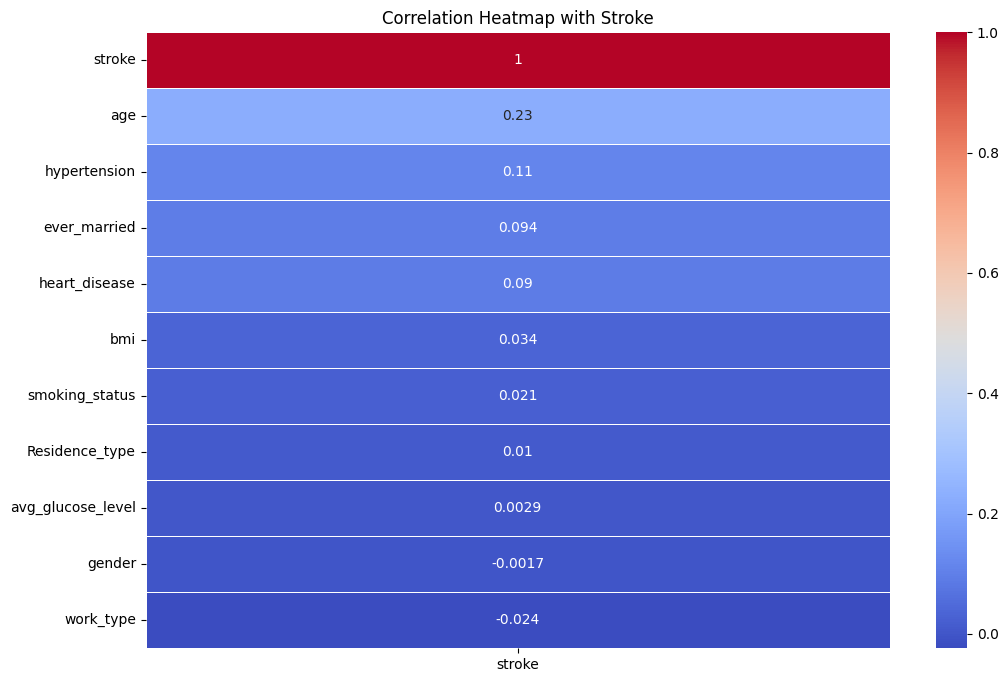

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Calculate correlation coefficients
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['stroke'].sort_values(ascending=False)

# Plot correlation values as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
plt.title('Correlation with Stroke')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Alternatively, you can use a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['stroke']].sort_values(by='stroke', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Stroke')
plt.show()


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve



In [51]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    prob_predictions = classifier.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score:", '{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()))

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [52]:
#Decision Tree
tree_model = DecisionTreeClassifier(criterion='gini')
tree_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = tree_model.predict(x_test)

print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, tree_model.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       833
           1       0.94      0.93      0.94       858

    accuracy                           0.93      1691
   macro avg       0.93      0.94      0.93      1691
weighted avg       0.93      0.93      0.93      1691

Train Accuracy:  1.0
Test Accuracy:  0.934949733885275


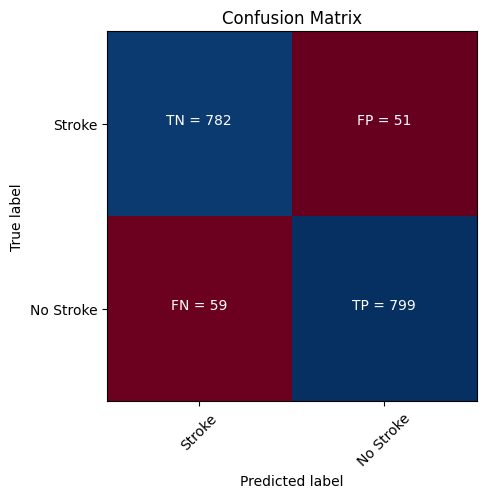

In [ ]:
#Make plots
plot_cm(tree_model, tree_model.predict(x_test).round())



Cross Validation Score: 91.78%


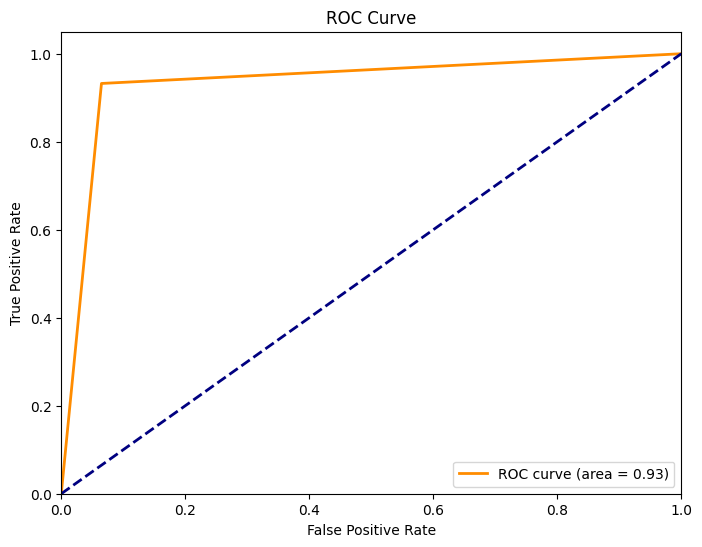

In [ ]:
model(tree_model,x_train,y_train,x_test,y_test)

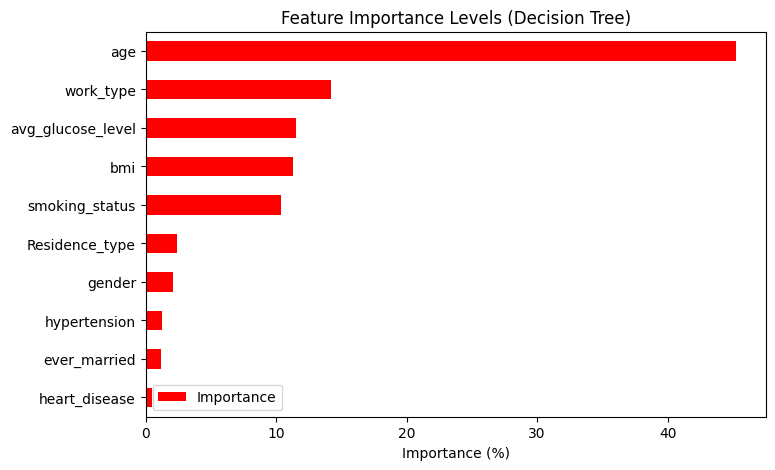

In [ ]:
# Feature Importances
X=df.drop(['stroke'],axis=1)
y=df['stroke']
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to store feature importance
Importance = pd.DataFrame({"Importance": tree_model.feature_importances_ * 100}, index=X.columns)

# Sort the DataFrame by importance in ascending order
Importance.sort_values(by="Importance", ascending=True, inplace=True)

# Select the top 10 most important features
top_10_features = Importance.tail(10)

# Create a horizontal bar plot
top_10_features.plot(kind="barh", color="r", figsize=(8, 5))
plt.title("Feature Importance Levels (Decision Tree)")
plt.xlabel("Importance (%)")
plt.show()


Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy on Test Set: 0.9426374926079243

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       833
           1       0.94      0.95      0.94       858

    accuracy                           0.94      1691
   macro avg       0.94      0.94      0.94      1691
weighted avg       0.94      0.94      0.94      1691



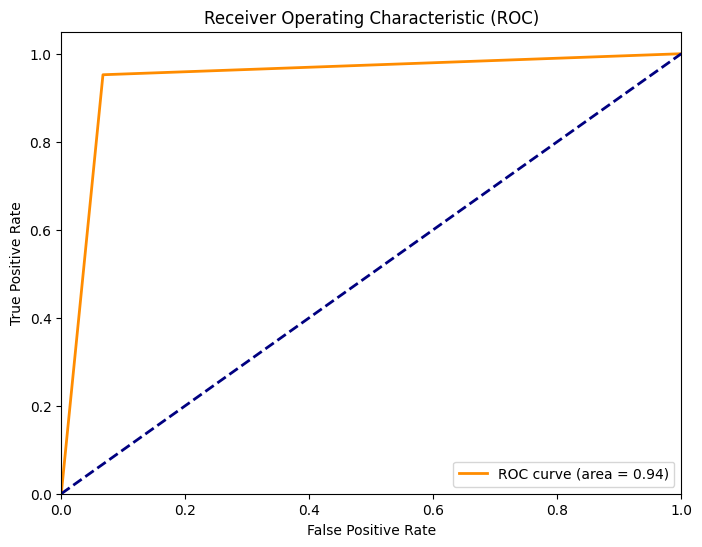

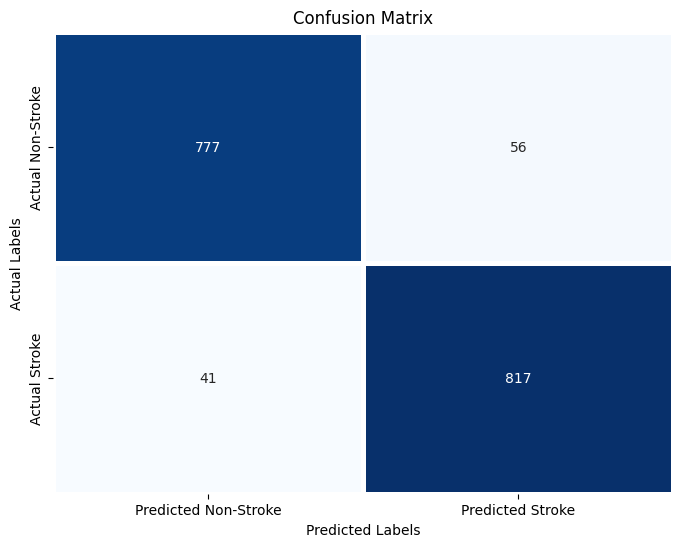

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Define the parameter grid for the grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2'],

}

# Create a grid search object with cross-validation
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_tree = best_tree_model.predict(x_test)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred_tree)
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

# ROC curve
roc_auc = roc_auc_score(y_test, best_tree_model.predict_proba(x_test)[:, 1])
fpr, tpr, _ = roc_curve(y_test, best_tree_model.predict_proba(x_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()


Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'gini'}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       833
           1       0.94      0.94      0.94       858

    accuracy                           0.94      1691
   macro avg       0.94      0.94      0.94      1691
weighted avg       0.94      0.94      0.94      1691

Test Accuracy:  0.9361324659964518


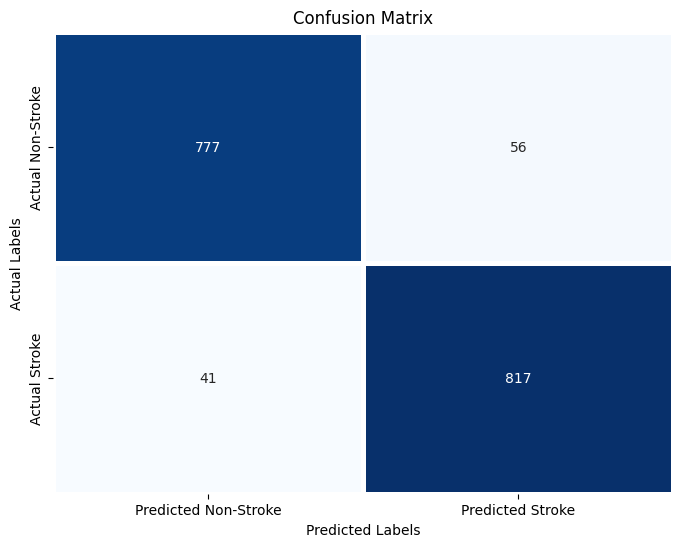

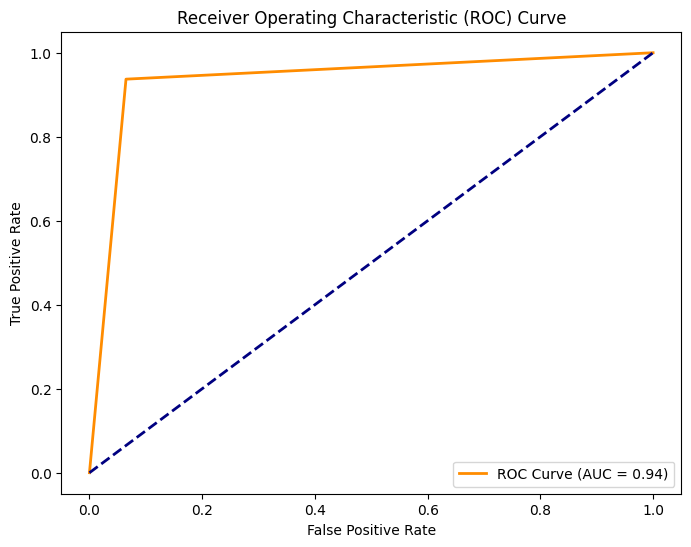

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Create a Decision Tree model
tree_model = DecisionTreeClassifier()

# Define the hyperparameters and their possible value ranges
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(10, 51, 10)),
    'min_samples_split': list(np.arange(2, 11)),
    'min_samples_leaf': list(np.arange(1, 5))
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(tree_model, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_tree_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_tree_model.predict(x_test)

# Print classification report and accuracy scores
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

# Confusion Matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve
y_prob = best_tree_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [53]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, knn.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.90      0.94       833
           1       0.91      0.99      0.95       858

    accuracy                           0.95      1691
   macro avg       0.95      0.95      0.95      1691
weighted avg       0.95      0.95      0.95      1691

Train Accuracy:  0.9616920573879604
Test Accuracy:  0.9467770549970431


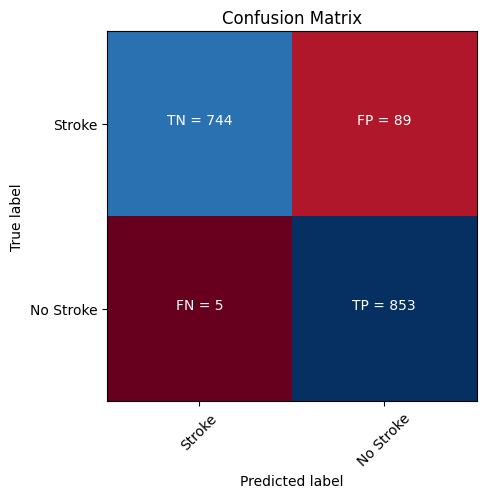

In [ ]:
#Make Plots
plot_cm(knn, knn.predict(x_test).round())



Cross Validation Score: 96.07%


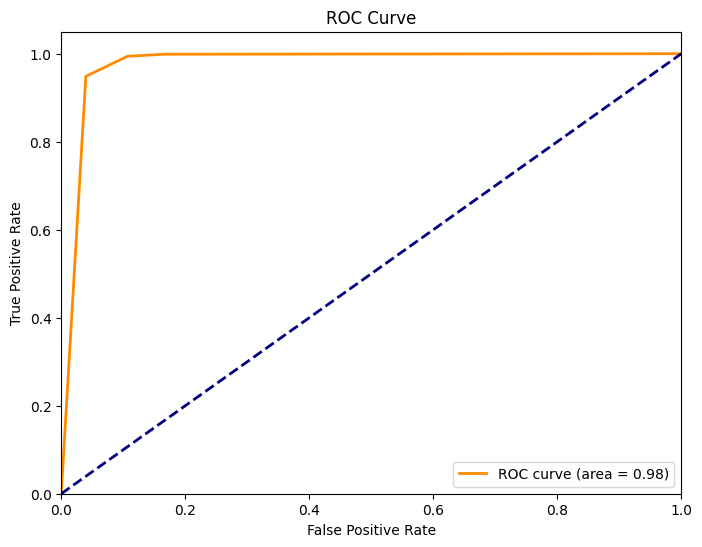

In [ ]:
model(knn,x_train,y_train,x_test,y_test)

Best Hyperparameters for KNN (Grid Search): {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Classification Report for KNN (Grid Search):
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       833
           1       0.95      0.98      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for KNN (Grid Search):  0.9680662329982259
Confusion Matrix for KNN (Grid Search):
 [[792  41]
 [ 13 845]]


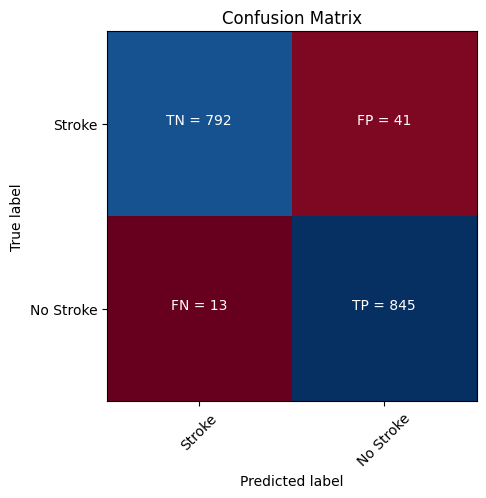

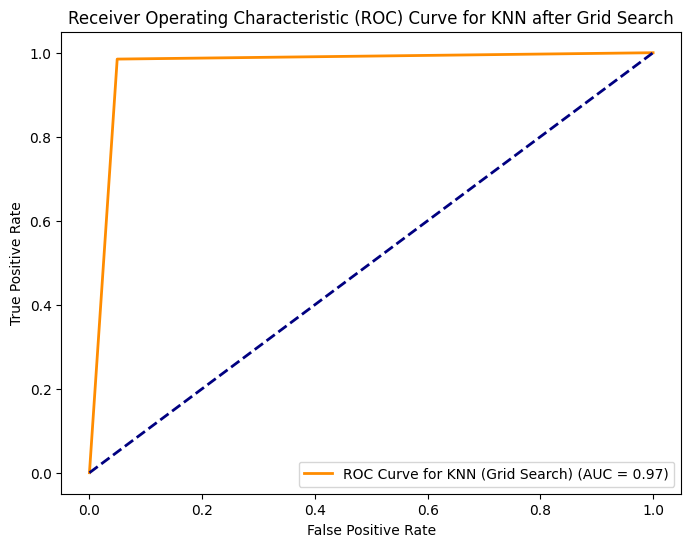

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Create a KNN model
knn_model = KNeighborsClassifier()

# Define the hyperparameter grid for the grid search
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create the GridSearchCV object
grid_search_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_knn.fit(x_train, y_train)

# Get the best hyperparameters
best_params_knn_grid = grid_search_knn.best_params_
print("Best Hyperparameters for KNN (Grid Search):", best_params_knn_grid)

# Get the best model
best_knn_model_grid = grid_search_knn.best_estimator_

# Make predictions on the test set using the best model
y_pred_knn_grid = best_knn_model_grid.predict(x_test)

# Print classification report and accuracy scores for KNN after grid search
print("Classification Report for KNN (Grid Search):\n", classification_report(y_test, y_pred_knn_grid))
print("Test Accuracy for KNN (Grid Search): ", accuracy_score(y_test, y_pred_knn_grid))

# Confusion Matrix for KNN after grid search
conf_matrix_knn_grid = confusion_matrix(y_test, y_pred_knn_grid)
print("Confusion Matrix for KNN (Grid Search):\n", conf_matrix_knn_grid)
plot_cm(best_knn_model_grid, y_pred_knn_grid)

# ROC Curve for KNN after grid search
y_prob_knn_grid = best_knn_model_grid.predict_proba(x_test)[:, 1]
fpr_knn_grid, tpr_knn_grid, thresholds_knn_grid = roc_curve(y_test, y_prob_knn_grid)
roc_auc_knn_grid = auc(fpr_knn_grid, tpr_knn_grid)

# Plot ROC Curve for KNN after grid search
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn_grid, tpr_knn_grid, color='darkorange', lw=2, label=f'ROC Curve for KNN (Grid Search) (AUC = {roc_auc_knn_grid:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN after Grid Search')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters for KNN (Grid Search): {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Classification Report for KNN (Grid Search):
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       833
           1       0.95      0.99      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for KNN (Grid Search):  0.9662921348314607
Confusion Matrix for KNN (Grid Search):
 [[787  46]
 [ 11 847]]


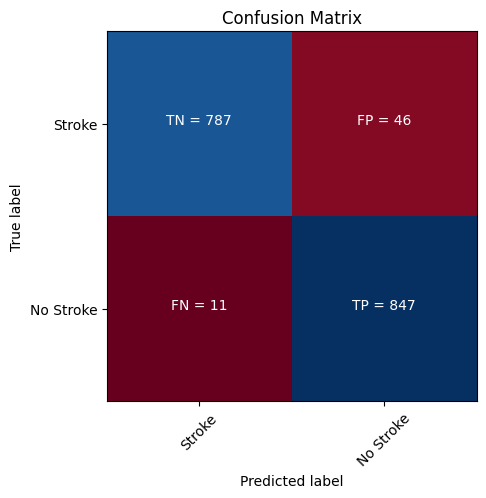

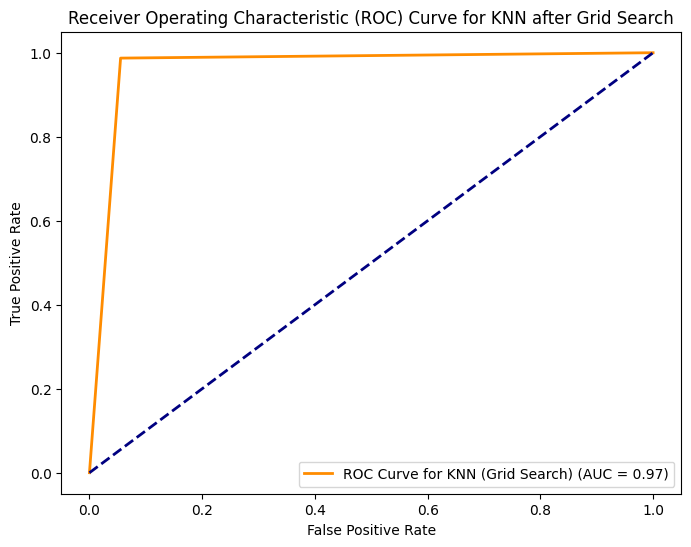

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Create a KNN model
knn_model = KNeighborsClassifier()

# Define the hyperparameter grid for the grid search
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create the GridSearchCV object
grid_search_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_knn.fit(x_train, y_train)

# Get the best hyperparameters
best_params_knn_grid = grid_search_knn.best_params_
print("Best Hyperparameters for KNN (Grid Search):", best_params_knn_grid)

# Get the best model
best_knn_model_grid = grid_search_knn.best_estimator_

# Make predictions on the test set using the best model
y_pred_knn_grid = best_knn_model_grid.predict(x_test)

# Print classification report and accuracy scores for KNN after grid search
print("Classification Report for KNN (Grid Search):\n", classification_report(y_test, y_pred_knn_grid))
print("Test Accuracy for KNN (Grid Search): ", accuracy_score(y_test, y_pred_knn_grid))

# Confusion Matrix for KNN after grid search
conf_matrix_knn_grid = confusion_matrix(y_test, y_pred_knn_grid)
print("Confusion Matrix for KNN (Grid Search):\n", conf_matrix_knn_grid)
plot_cm(best_knn_model_grid, y_pred_knn_grid)

# ROC Curve for KNN after grid search
y_prob_knn_grid = best_knn_model_grid.predict_proba(x_test)[:, 1]
fpr_knn_grid, tpr_knn_grid, thresholds_knn_grid = roc_curve(y_test, y_prob_knn_grid)
roc_auc_knn_grid = auc(fpr_knn_grid, tpr_knn_grid)

# Plot ROC Curve for KNN after grid search
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn_grid, tpr_knn_grid, color='darkorange', lw=2, label=f'ROC Curve for KNN (Grid Search) (AUC = {roc_auc_knn_grid:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN after Grid Search')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters for KNN: {'weights': 'distance', 'p': 2, 'n_neighbors': 2, 'algorithm': 'kd_tree'}
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       833
           1       0.95      1.00      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for KNN:  0.9698403311649911
Confusion Matrix for KNN:
 [[786  47]
 [  4 854]]


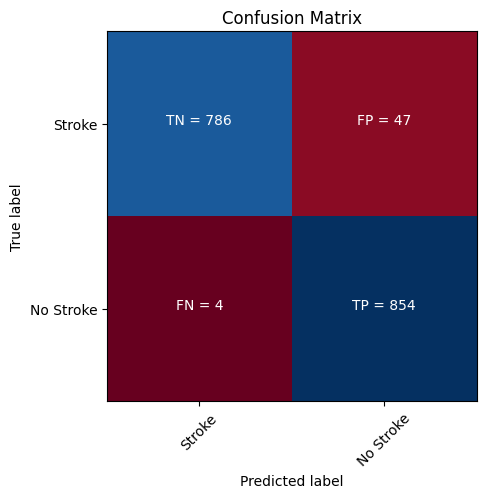

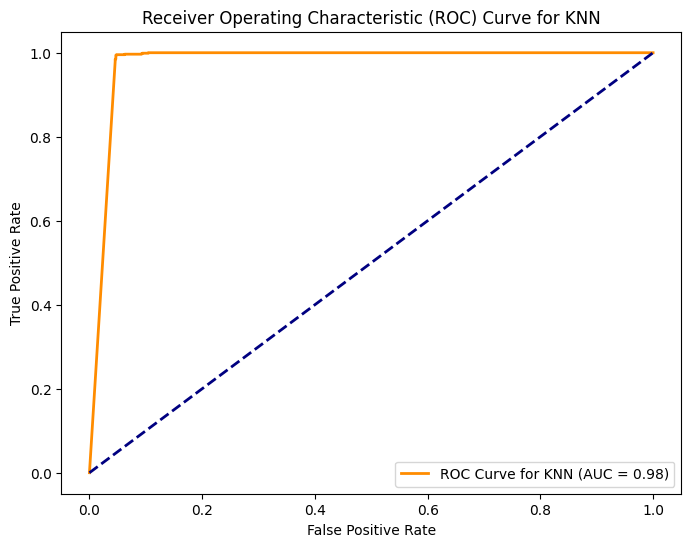

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Create a KNN model
knn_model = KNeighborsClassifier()

# Define the hyperparameters and their possible value ranges
param_dist = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create the RandomizedSearchCV object
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist, n_iter=10,
                                       cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search_knn.fit(x_train, y_train)

# Get the best hyperparameters
best_params_knn = random_search_knn.best_params_
print("Best Hyperparameters for KNN:", best_params_knn)

# Get the best model
best_knn_model = random_search_knn.best_estimator_

# Make predictions on the test set using the best model
y_pred_knn = best_knn_model.predict(x_test)

# Print classification report and accuracy scores for KNN
print("Classification Report for KNN:\n", classification_report(y_test, y_pred_knn))
print("Test Accuracy for KNN: ", accuracy_score(y_test, y_pred_knn))


# Confusion Matrix for KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for KNN:\n", conf_matrix_knn)
plot_cm(best_knn_model, y_pred_knn)

# ROC Curve for KNN
y_prob_knn = best_knn_model.predict_proba(x_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curve for KNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC Curve for KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc="lower right")
plt.show()



In [54]:
#Logistic Regression

lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

LogisticRegression()

In [ ]:
y_pred = lr_model.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, lr_model.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.79      0.80       833
           1       0.80      0.82      0.81       858

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691

Train Accuracy:  0.7828723561603314
Test Accuracy:  0.8066232998225902


In [55]:
y_pred = lr_model.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, lr_model.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.80      0.80       833
           1       0.81      0.81      0.81       858

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691

Train Accuracy:  0.7858304984469753
Test Accuracy:  0.8054405677114134


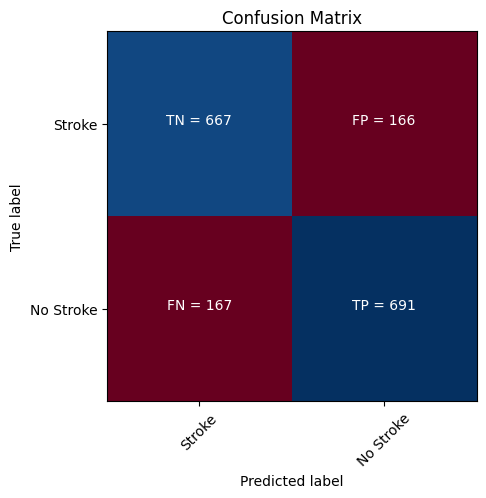

In [ ]:
plot_cm(lr_model, lr_model.predict(x_test).round())


Cross Validation Score: 85.60%


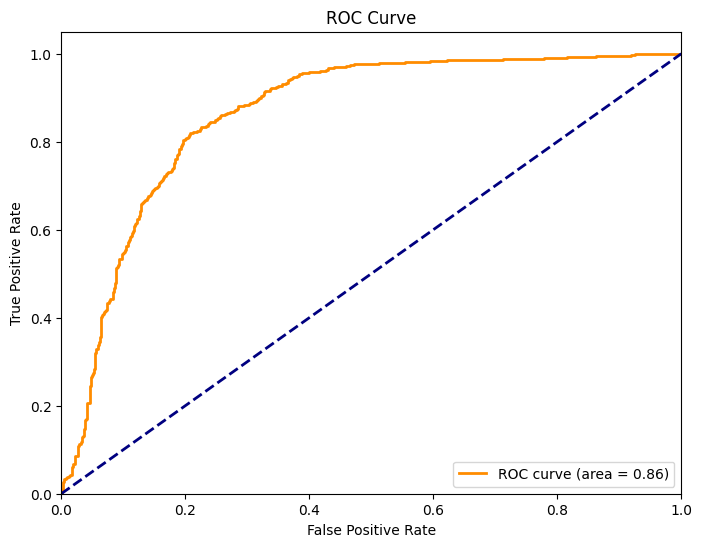

In [ ]:
model(lr_model,x_train,y_train,x_test,y_test)

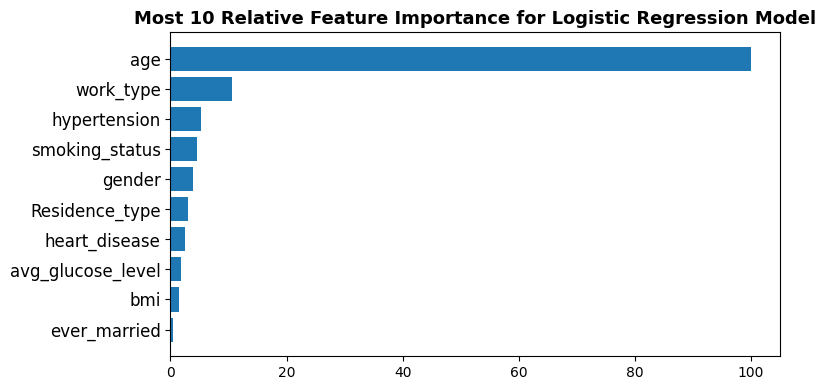

In [ ]:
# Feature Importances
X=df.drop(['stroke'],axis=1)
y=df['stroke']
feature_importance = abs(lr_model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())[0:10]
sorted_idx = np.argsort(feature_importance)[0:10]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 4))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Most 10 Relative Feature Importance for Logistic Regression Model', fontsize=13, fontweight='bold')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=12)

plt.tight_layout()
plt.show()

Best Hyperparameters for Logistic Regression (Grid Search): {'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report for Logistic Regression (Grid Search):
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       833
           1       0.81      0.84      0.82       858

    accuracy                           0.82      1691
   macro avg       0.82      0.82      0.82      1691
weighted avg       0.82      0.82      0.82      1691

Test Accuracy for Logistic Regression (Grid Search):  0.8160851567120048
Confusion Matrix for Logistic Regression (Grid Search):
 [[662 171]
 [140 718]]


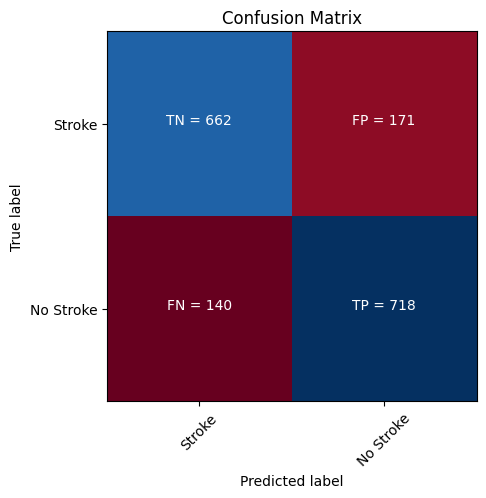

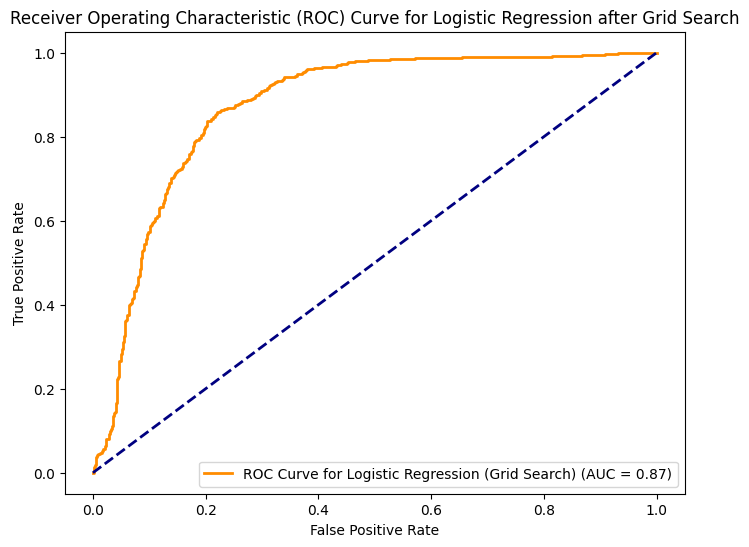

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Create a Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Define the hyperparameter grid for the grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [50, 100, 200],
     'multi_class': ['auto', 'ovr', 'multinomial'],
    'l1_ratio': [0.1, 0.5, 0.9],

}

# Create the GridSearchCV object
grid_search_lr = GridSearchCV(lr_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_lr.fit(x_train, y_train)

# Get the best hyperparameters
best_params_lr = grid_search_lr.best_params_
print("Best Hyperparameters for Logistic Regression (Grid Search):", best_params_lr)

# Get the best model
best_lr_model = grid_search_lr.best_estimator_

# Make predictions on the test set using the best model
y_pred_lr = best_lr_model.predict(x_test)

# Print classification report and accuracy scores for LR after grid search
print("Classification Report for Logistic Regression (Grid Search):\n", classification_report(y_test, y_pred_lr))
print("Test Accuracy for Logistic Regression (Grid Search): ", accuracy_score(y_test, y_pred_lr))

# Confusion Matrix for LR after grid search
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix for Logistic Regression (Grid Search):\n", conf_matrix_lr)
plot_cm(best_lr_model, y_pred_lr)

# ROC Curve for LR after grid search
y_prob_lr = best_lr_model.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC Curve for LR after grid search
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC Curve for Logistic Regression (Grid Search) (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression after Grid Search')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters for Logistic Regression (Randomized Search): {'C': 3.6896947354532794, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
Classification Report for Logistic Regression (Randomized Search):
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       833
           1       0.81      0.83      0.82       858

    accuracy                           0.82      1691
   macro avg       0.82      0.82      0.82      1691
weighted avg       0.82      0.82      0.82      1691

Test Accuracy for Logistic Regression (Randomized Search):  0.8154937906564164
Confusion Matrix for Logistic Regression (Randomized Search):
 [[663 170]
 [142 716]]


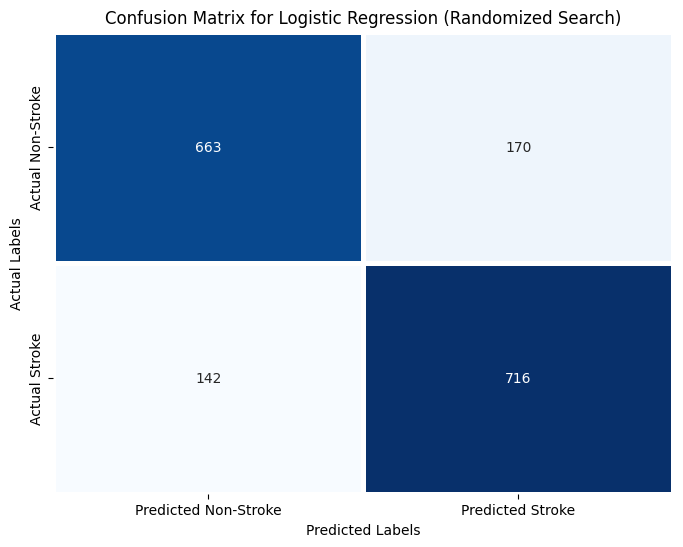

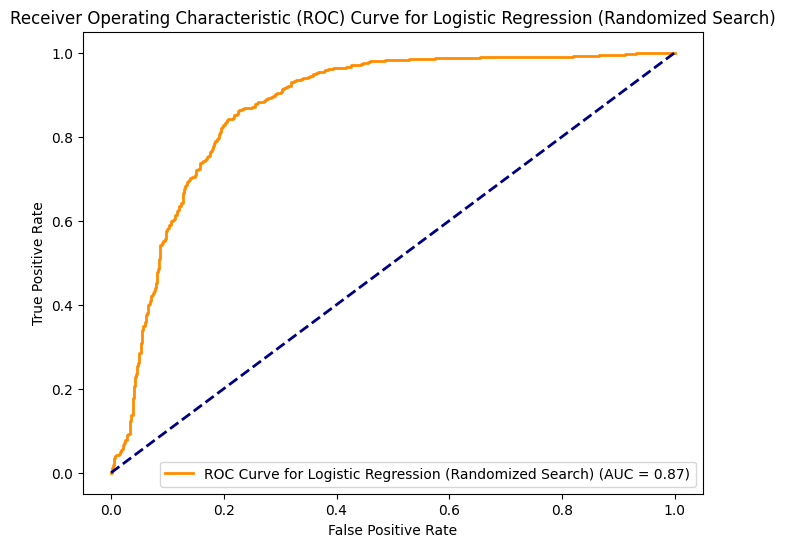

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Create a Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Define the hyperparameter distribution for the randomized search
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.001, 100),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 300],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True]
}

# Create the RandomizedSearchCV object
random_search_lr = RandomizedSearchCV(lr_model, param_distributions=param_dist_lr, n_iter=50,
                                       cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Fit the randomized search to the data
random_search_lr.fit(x_train, y_train)

# Get the best hyperparameters
best_params_lr_random = random_search_lr.best_params_
print("Best Hyperparameters for Logistic Regression (Randomized Search):", best_params_lr_random)

# Get the best model
best_lr_model_random = random_search_lr.best_estimator_

# Make predictions on the test set using the best model
y_pred_lr_random = best_lr_model_random.predict(x_test)

# Print classification report and accuracy scores for LR after randomized search
print("Classification Report for Logistic Regression (Randomized Search):\n", classification_report(y_test, y_pred_lr_random))
print("Test Accuracy for Logistic Regression (Randomized Search): ", accuracy_score(y_test, y_pred_lr_random))

# Confusion Matrix for LR after randomized search
conf_matrix_lr_random = confusion_matrix(y_test, y_pred_lr_random)
print("Confusion Matrix for Logistic Regression (Randomized Search):\n", conf_matrix_lr_random)

# Plot Confusion Matrix for LR
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_random, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Logistic Regression (Randomized Search)')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve for LR after randomized search
y_prob_lr_random = best_lr_model_random.predict_proba(x_test)[:, 1]
fpr_lr_random, tpr_lr_random, thresholds_lr_random = roc_curve(y_test, y_prob_lr_random)
roc_auc_lr_random = auc(fpr_lr_random, tpr_lr_random)

# Plot ROC Curve for LR after randomized search
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_random, tpr_lr_random, color='darkorange', lw=2, label=f'ROC Curve for Logistic Regression (Randomized Search) (AUC = {roc_auc_lr_random:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression (Randomized Search)')
plt.legend(loc="lower right")
plt.show()


In [56]:
#Support Vector Classifier
svm = SVC()
svm.fit(x_train , y_train)

SVC()

In [ ]:
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, svm.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       833
           1       0.85      0.94      0.90       858

    accuracy                           0.89      1691
   macro avg       0.89      0.89      0.89      1691
weighted avg       0.89      0.89      0.89      1691

Train Accuracy:  0.8695459251590002
Test Accuracy:  0.8900059136605559


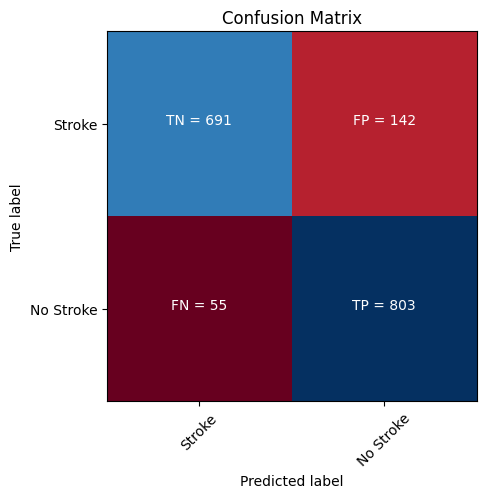

In [ ]:
plot_cm(svm, svm.predict(x_test).round())

Cross Validation Score: 92.42%


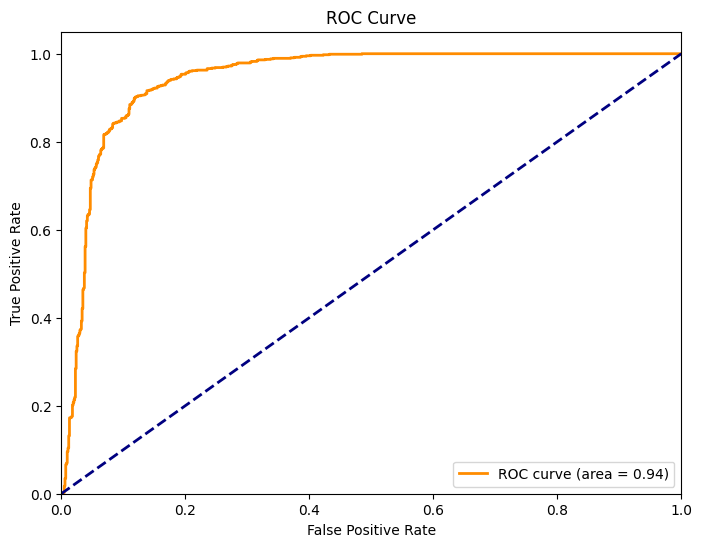

In [ ]:
# Initialize the SVM model with probability=True
svm = SVC(probability=True)
model(svm,x_train,y_train,x_test,y_test)

Best Hyperparameters for SVC (Randomized Search): {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 1000.0}
Classification Report for SVC (Randomized Search):
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       833
           1       0.94      1.00      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for SVC (Randomized Search):  0.9657007687758723
Confusion Matrix for SVC (Randomized Search):
 [[777  56]
 [  2 856]]


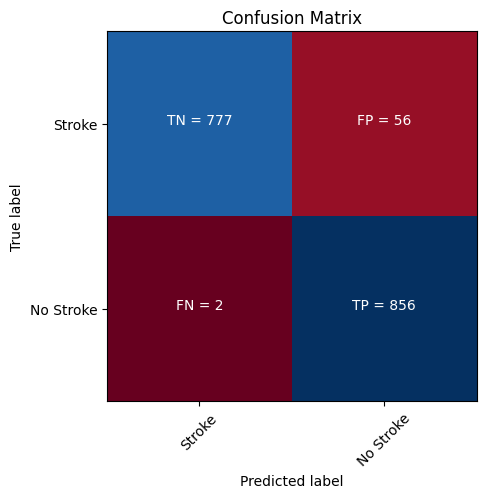

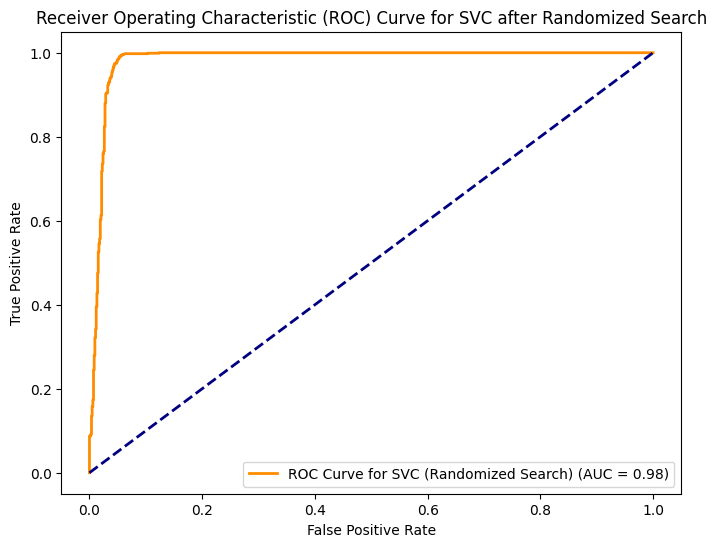

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Create an SVC model
svc_model = SVC(probability=True, random_state=42)

# Define the hyperparameter grid for the randomized search
param_dist = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', np.logspace(-3, 3, 7)],
}

# Create the RandomizedSearchCV object
random_search_svc = RandomizedSearchCV(svc_model, param_distributions=param_dist, n_iter=10,
                                       cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search_svc.fit(x_train, y_train)

# Get the best hyperparameters
best_params_svc_random = random_search_svc.best_params_
print("Best Hyperparameters for SVC (Randomized Search):", best_params_svc_random)

# Get the best model
best_svc_model_random = random_search_svc.best_estimator_

# Make predictions on the test set using the best model
y_pred_svc_random = best_svc_model_random.predict(x_test)

# Print classification report and accuracy scores for SVC after random search
print("Classification Report for SVC (Randomized Search):\n", classification_report(y_test, y_pred_svc_random))
print("Test Accuracy for SVC (Randomized Search): ", accuracy_score(y_test, y_pred_svc_random))

# Confusion Matrix for SVC after random search
conf_matrix_svc_random = confusion_matrix(y_test, y_pred_svc_random)
print("Confusion Matrix for SVC (Randomized Search):\n", conf_matrix_svc_random)

# Plot Confusion Matrix for SVC after random search
plot_cm(best_svc_model_random, y_pred_svc_random)

# ROC Curve for SVC after random search
y_prob_svc_random = best_svc_model_random.predict_proba(x_test)[:, 1]
fpr_svc_random, tpr_svc_random, thresholds_svc_random = roc_curve(y_test, y_prob_svc_random)
roc_auc_svc_random = auc(fpr_svc_random, tpr_svc_random)

# Plot ROC Curve for SVC after random search
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc_random, tpr_svc_random, color='darkorange', lw=2, label=f'ROC Curve for SVC (Randomized Search) (AUC = {roc_auc_svc_random:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC after Randomized Search')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters for SVC (Grid Search): {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report for SVC (Grid Search):
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       833
           1       0.90      0.97      0.94       858

    accuracy                           0.93      1691
   macro avg       0.94      0.93      0.93      1691
weighted avg       0.94      0.93      0.93      1691

Test Accuracy for SVC (Grid Search):  0.9337670017740982
Confusion Matrix for SVC (Grid Search):
 [[745  88]
 [ 24 834]]


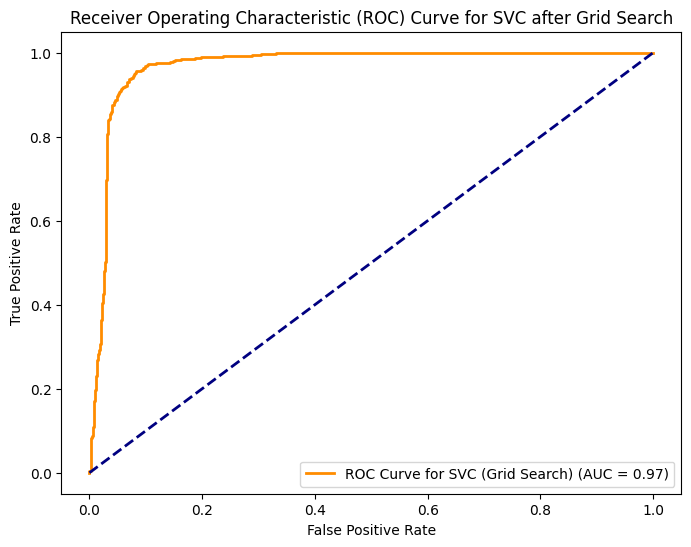

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Create an SVC model
svc_model = SVC(probability=True, random_state=42)

# Define the hyperparameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
}

# Create the GridSearchCV object
grid_search_svc = GridSearchCV(svc_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
grid_search_svc.fit(x_train, y_train)

# Get the best hyperparameters
best_params_svc = grid_search_svc.best_params_
print("Best Hyperparameters for SVC (Grid Search):", best_params_svc)

# Get the best model
best_svc_model = grid_search_svc.best_estimator_

# Make predictions on the test set using the best model
y_pred_svc = best_svc_model.predict(x_test)

# Print classification report and accuracy scores for SVC after grid search
print("Classification Report for SVC (Grid Search):\n", classification_report(y_test, y_pred_svc))
print("Test Accuracy for SVC (Grid Search): ", accuracy_score(y_test, y_pred_svc))

# Confusion Matrix for SVC after grid search
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
print("Confusion Matrix for SVC (Grid Search):\n", conf_matrix_svc)

# ROC Curve for SVC after grid search
y_prob_svc = best_svc_model.predict_proba(x_test)[:, 1]
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot ROC Curve for SVC after grid search
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC Curve for SVC (Grid Search) (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC after Grid Search')
plt.legend(loc="lower right")
plt.show()


In [57]:
rf_regr = RandomForestClassifier(n_estimators=5,criterion='entropy',random_state = 123)
rf_regr.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=123)

In [ ]:
y_pred = rf_regr.predict(x_test)

print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, rf_regr.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       833
           1       0.96      0.96      0.96       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691

Train Accuracy:  0.9936399940837154
Test Accuracy:  0.9556475458308693


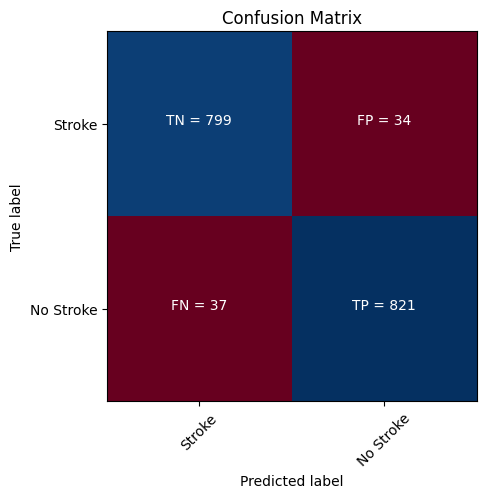

In [ ]:
plot_cm(rf_regr, rf_regr.predict(x_test).round())

Cross Validation Score: 98.38%


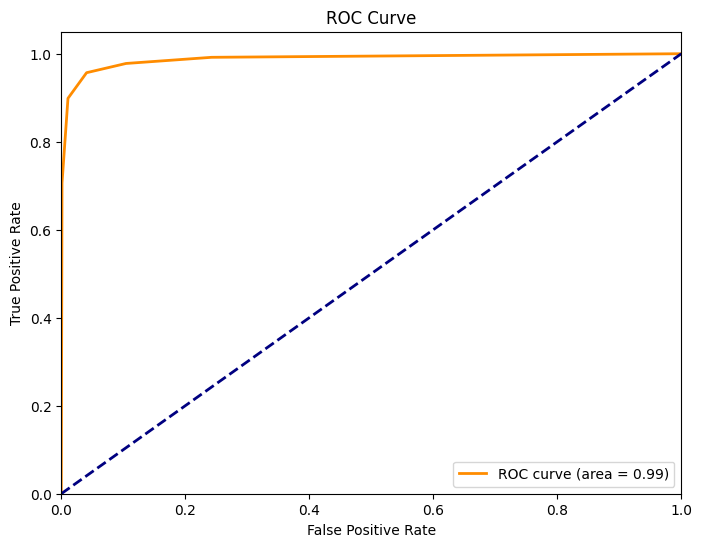

In [ ]:
model(rf_regr,x_train,y_train,x_test,y_test)

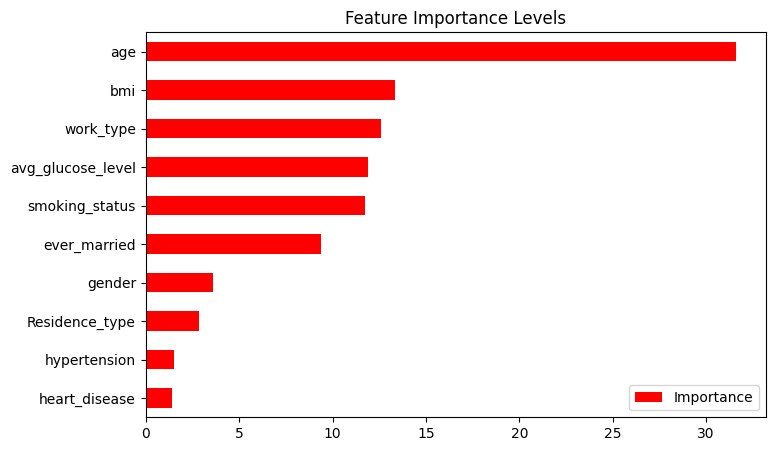

In [ ]:
Importance =pd.DataFrame({"Importance": rf_regr.feature_importances_*100},index = x.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(10).plot(kind ="barh", color = "r",figsize=(8, 5))
plt.title("Feature Importance Levels");
plt.show()

Best Hyperparameters for Random Forest (Grid Search): {'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report for Random Forest (Grid Search):
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       833
           1       0.98      0.97      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Test Accuracy for Random Forest (Grid Search):  0.9757539917208752
Confusion Matrix for Random Forest (Grid Search):
 [[819  14]
 [ 27 831]]


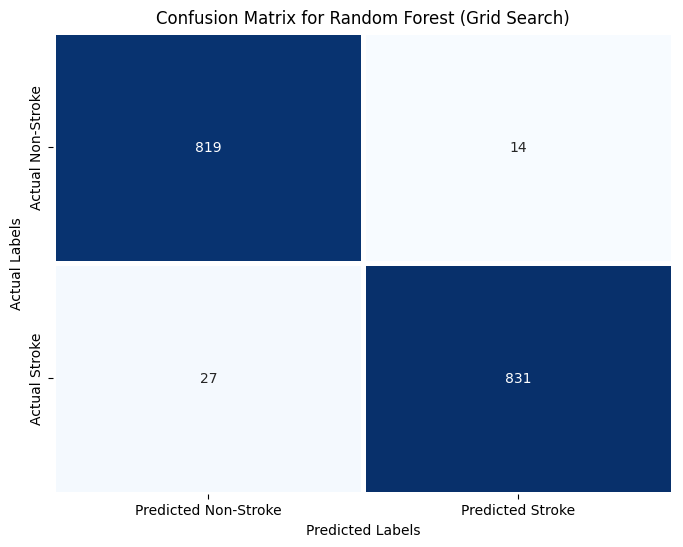

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(x_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest (Grid Search):", best_params_rf)

# Get the best model
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf = best_rf_model.predict(x_test)

# Print classification report and accuracy scores for Random Forest after grid search
print("Classification Report for Random Forest (Grid Search):\n", classification_report(y_test, y_pred_rf))
print("Test Accuracy for Random Forest (Grid Search): ", accuracy_score(y_test, y_pred_rf))

# Confusion Matrix for Random Forest after grid search
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest (Grid Search):\n", conf_matrix_rf)

# Plot Confusion Matrix for Random Forest after grid search
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Random Forest (Grid Search)')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()


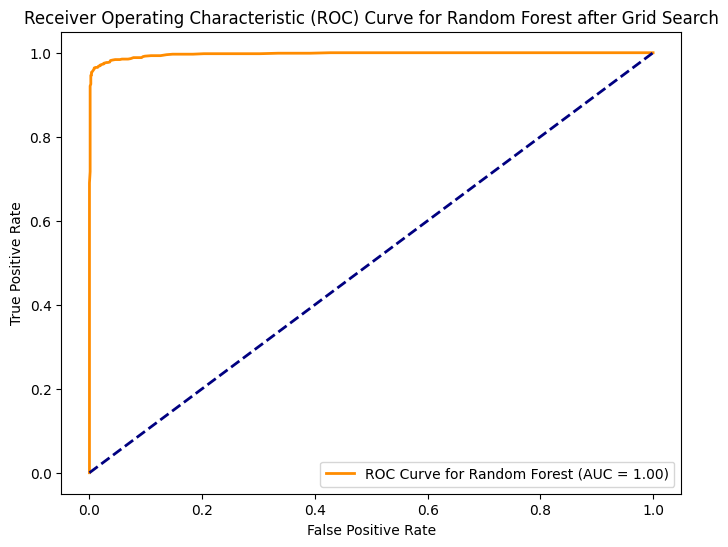

In [ ]:

# ROC Curve for Random Forest after grid search
y_prob_rf = best_rf_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve for Random Forest after grid search
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC Curve for Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest after Grid Search')
plt.legend(loc="lower right")
plt.show()








Best Hyperparameters for Random Forest (Randomized Search): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Classification Report for Random Forest (Randomized Search):
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       833
           1       0.98      0.97      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for Random Forest (Randomized Search):  0.9733885274985216
Confusion Matrix for Random Forest (Randomized Search):
 [[817  16]
 [ 29 829]]


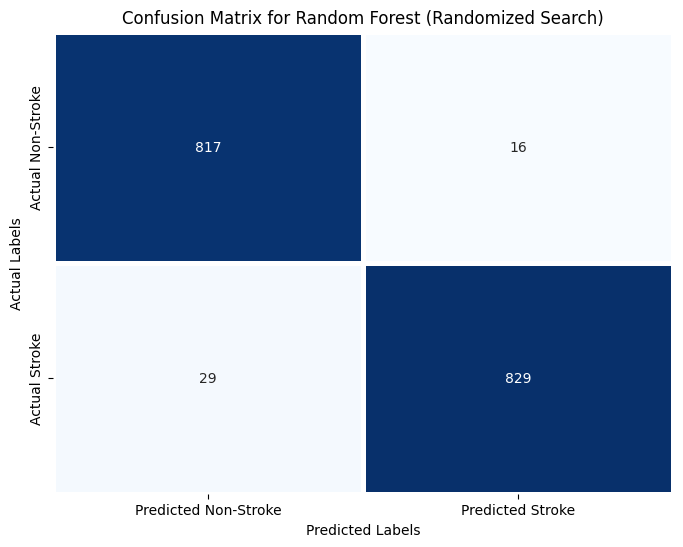

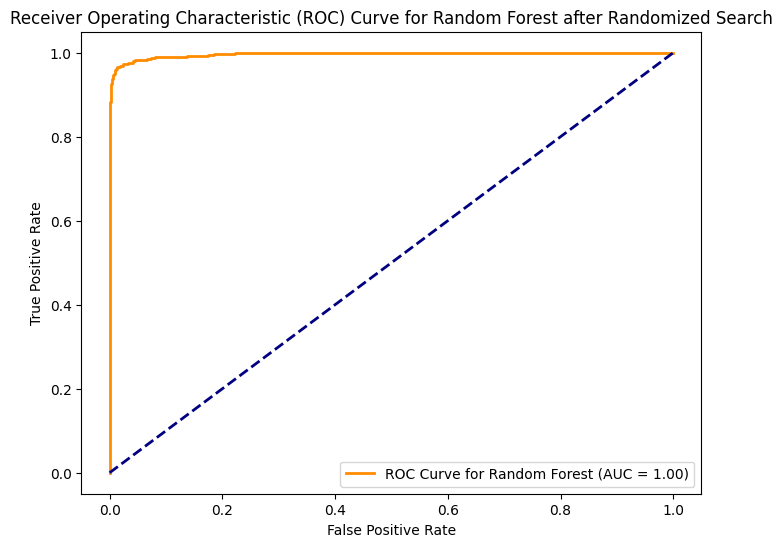

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter distribution for the randomized search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10,
                                       cv=5, scoring='roc_auc', n_jobs=-1, random_state=42)

# Fit the random search to the data
random_search_rf.fit(x_train, y_train)

# Get the best hyperparameters
best_params_rf_random = random_search_rf.best_params_
print("Best Hyperparameters for Random Forest (Randomized Search):", best_params_rf_random)

# Get the best model
best_rf_model_random = random_search_rf.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf_random = best_rf_model_random.predict(x_test)

# Print classification report and accuracy scores for Random Forest after random search
print("Classification Report for Random Forest (Randomized Search):\n", classification_report(y_test, y_pred_rf_random))
print("Test Accuracy for Random Forest (Randomized Search): ", accuracy_score(y_test, y_pred_rf_random))

# Confusion Matrix for Random Forest after random search
conf_matrix_rf_random = confusion_matrix(y_test, y_pred_rf_random)
print("Confusion Matrix for Random Forest (Randomized Search):\n", conf_matrix_rf_random)

# Plot Confusion Matrix for Random Forest after random search
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_random, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Random Forest (Randomized Search)')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve for Random Forest after random search
y_prob_rf_random = best_rf_model_random.predict_proba(x_test)[:, 1]
fpr_rf_random, tpr_rf_random, thresholds_rf_random = roc_curve(y_test, y_prob_rf_random)
roc_auc_rf_random = auc(fpr_rf_random, tpr_rf_random)

# Plot ROC Curve for Random Forest after random search
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_random, tpr_rf_random, color='darkorange', lw=2, label=f'ROC Curve for Random Forest (AUC = {roc_auc_rf_random:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest after Randomized Search')
plt.legend(loc="lower right")
plt.show()


In [58]:
from xgboost import XGBClassifier

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       833
           1       0.98      0.95      0.96       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691

XGBoost Accuracy: 0.9627439384979303


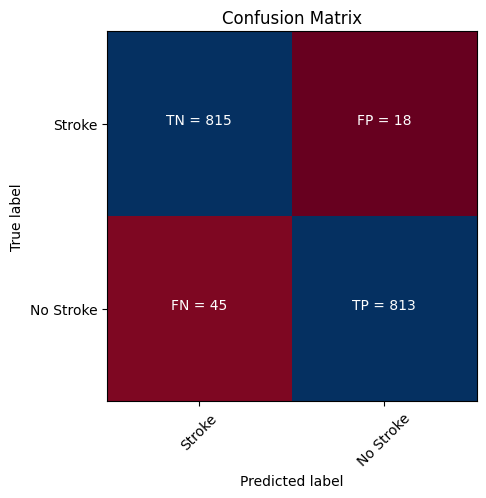

In [ ]:
y_pred_xgb = xgb_model.predict(x_test)

# Evaluate XGBoost
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
plot_cm(xgb_model, xgb_model.predict(x_test).round())


Cross Validation Score: 99.41%


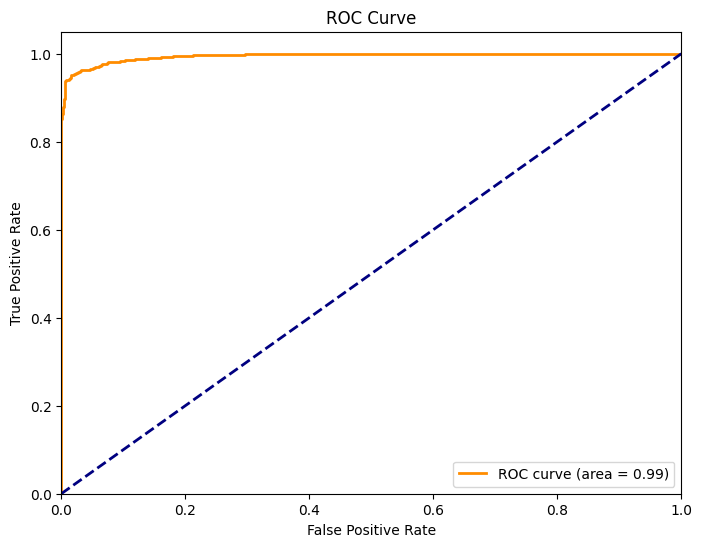

In [ ]:
model(xgb_model,x_train,y_train,x_test,y_test)

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Accuracy: 0.965686268
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       833
           1       0.98      0.95      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy: 0.97
Confusion Matrix:
[[819  14]
 [ 43 815]]


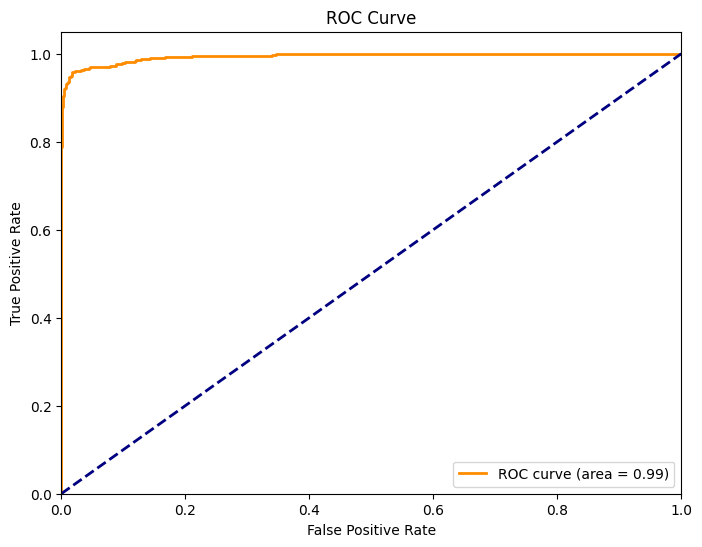

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: {:.9f}".format(grid_search.best_score_))

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(x_test)

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Test Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# ROC Curve
prob_predictions = best_xgb_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, prob_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


Best Parameters: {'colsample_bytree': 0.8192353102182842, 'gamma': 0, 'learning_rate': 0.14818754762049322, 'max_depth': 5, 'n_estimators': 181, 'subsample': 0.9675420211814656}
Best Accuracy: 0.960360387
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       833
           1       0.98      0.95      0.96       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.97      0.96      0.96      1691

Test Accuracy: 0.964518037
Confusion Matrix:
[[817  16]
 [ 44 814]]


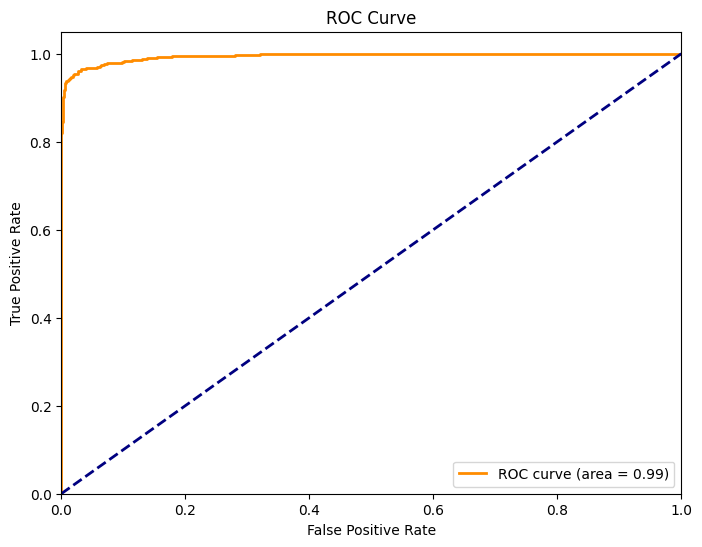

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import scipy.stats

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the parameter distribution for randomized search
param_dist = {
    'learning_rate': scipy.stats.uniform(0.01, 0.2),
    'n_estimators': scipy.stats.randint(100, 300),
    'max_depth': scipy.stats.randint(3, 6),
    'subsample': scipy.stats.uniform(0.8, 0.2),
    'colsample_bytree': scipy.stats.uniform(0.8, 0.2),
    'gamma': scipy.stats.randint(0, 3)

}

# Use StratifiedKFold for better handling of imbalanced datasets
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='accuracy', cv=cv, n_iter=50, n_jobs=-1, random_state=42)

# Perform randomized search on the training data
random_search.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy: {:.9f}".format(random_search.best_score_))

# Get the best model from randomized search
best_xgb_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(x_test)

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Test Accuracy: {:.9f}".format(accuracy_score(y_test, y_pred)))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# ROC Curve
prob_predictions = best_xgb_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, prob_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define the AdaBoost model
adaboost_model = AdaBoostClassifier()

# Train the model
adaboost_model.fit(x_train, y_train)

AdaBoostClassifier()

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       833
           1       0.88      0.91      0.89       858

    accuracy                           0.89      1691
   macro avg       0.89      0.89      0.89      1691
weighted avg       0.89      0.89      0.89      1691

Test Accuracy: 0.89000591
Confusion Matrix:
[[716 117]
 [ 78 780]]


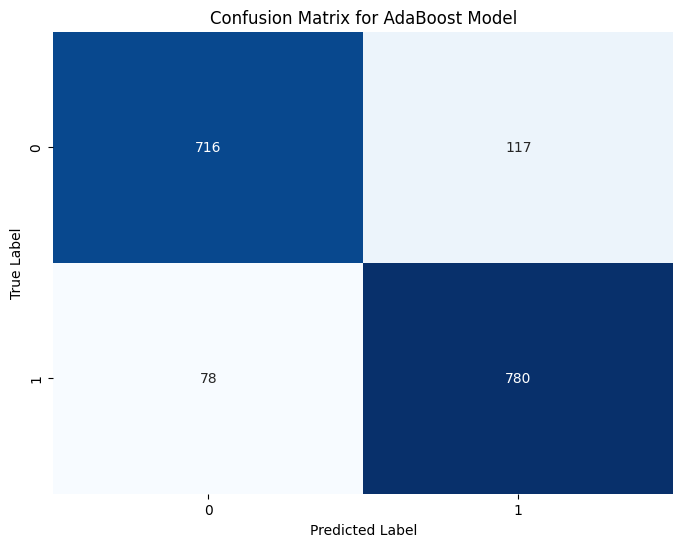

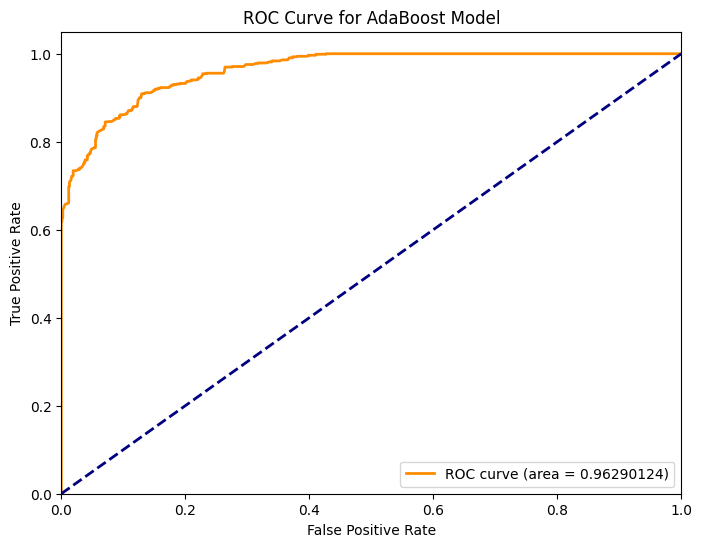

In [ ]:
# Make predictions on the test set
y_pred_adaboost = adaboost_model.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_adaboost))

# Accuracy score
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("Test Accuracy: {:.8f}".format(accuracy_adaboost))  # Adjust the number of decimal places

# Print confusion matrix
print("Confusion Matrix:")
print(conf_mat_adaboost)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_adaboost, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix for AdaBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
prob_predictions_adaboost = adaboost_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, prob_predictions_adaboost)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_adaboost))  # Adjust the number of decimal places
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost Model')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()

Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 250}
Best Accuracy: 0.89113968
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       833
           1       0.91      0.90      0.91       858

    accuracy                           0.91      1691
   macro avg       0.91      0.91      0.91      1691
weighted avg       0.91      0.91      0.91      1691

Test Accuracy: 0.90538143
Confusion Matrix:
[[760  73]
 [ 87 771]]


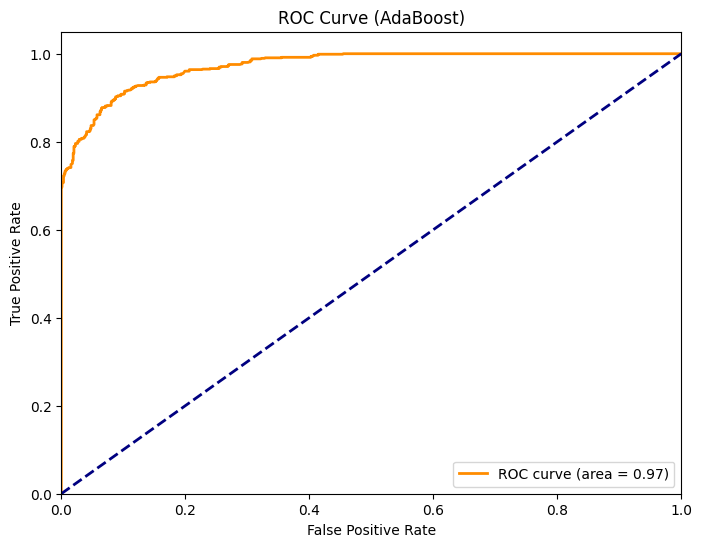

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define the AdaBoost model
adaboost_model = AdaBoostClassifier()
param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'algorithm': ['SAMME', 'SAMME.R']
}



# Create a GridSearchCV object
grid_search_adaboost = GridSearchCV(estimator=adaboost_model, param_grid=param_grid_adaboost, scoring='accuracy', cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search_adaboost.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", grid_search_adaboost.best_params_)
print("Best Accuracy: {:.8f}".format(grid_search_adaboost.best_score_))  # Adjust the number of decimal places

# Get the best model from grid search
best_adaboost_model = grid_search_adaboost.best_estimator_

# Evaluate the best model on the test set
y_pred_best_adaboost = best_adaboost_model.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_best_adaboost))
accuracy_best_adaboost = accuracy_score(y_test, y_pred_best_adaboost)
print("Test Accuracy: {:.8f}".format(accuracy_best_adaboost))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_adaboost = confusion_matrix(y_test, y_pred_best_adaboost)
print("Confusion Matrix:")
print(conf_mat_adaboost)

# ROC Curve
prob_predictions_adaboost = best_adaboost_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, prob_predictions_adaboost)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_adaboost, tpr_adaboost, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_adaboost)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost)')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


Best Parameters: {'n_estimators': 280, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
Best Accuracy: 0.90030920
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       833
           1       0.94      0.88      0.91       858

    accuracy                           0.91      1691
   macro avg       0.91      0.91      0.91      1691
weighted avg       0.91      0.91      0.91      1691

Test Accuracy: 0.90952099
Confusion Matrix:
[[781  52]
 [101 757]]


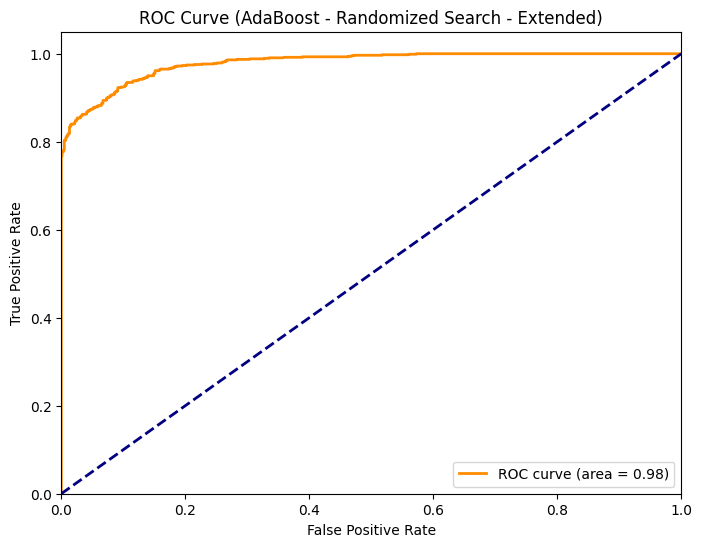

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define the AdaBoost model
adaboost_model = AdaBoostClassifier()

# Define the extended parameter grid for randomized search
param_dist_adaboost_extended = {
    'n_estimators': np.arange(50, 301, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a RandomizedSearchCV object with more iterations
random_search_adaboost_extended = RandomizedSearchCV(estimator=adaboost_model,
                                                      param_distributions=param_dist_adaboost_extended,
                                                      scoring='accuracy', cv=5, n_iter=100, n_jobs=-1, random_state=42)

# Perform randomized search on the training data
random_search_adaboost_extended.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", random_search_adaboost_extended.best_params_)
print("Best Accuracy: {:.8f}".format(random_search_adaboost_extended.best_score_))  # Adjust the number of decimal places

# Get the best model from randomized search
best_adaboost_model_extended = random_search_adaboost_extended.best_estimator_

# Evaluate the best model on the test set
y_pred_best_adaboost_extended = best_adaboost_model_extended.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_best_adaboost_extended))
accuracy_best_adaboost_extended = accuracy_score(y_test, y_pred_best_adaboost_extended)
print("Test Accuracy: {:.8f}".format(accuracy_best_adaboost_extended))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_adaboost_extended = confusion_matrix(y_test, y_pred_best_adaboost_extended)
print("Confusion Matrix:")
print(conf_mat_adaboost_extended)

# ROC Curve
prob_predictions_adaboost_extended = best_adaboost_model_extended.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_adaboost_extended, tpr_adaboost_extended, _ = roc_curve(y_test, prob_predictions_adaboost_extended)
roc_auc_adaboost_extended = auc(fpr_adaboost_extended, tpr_adaboost_extended)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_adaboost_extended, tpr_adaboost_extended, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_adaboost_extended)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost - Randomized Search )')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


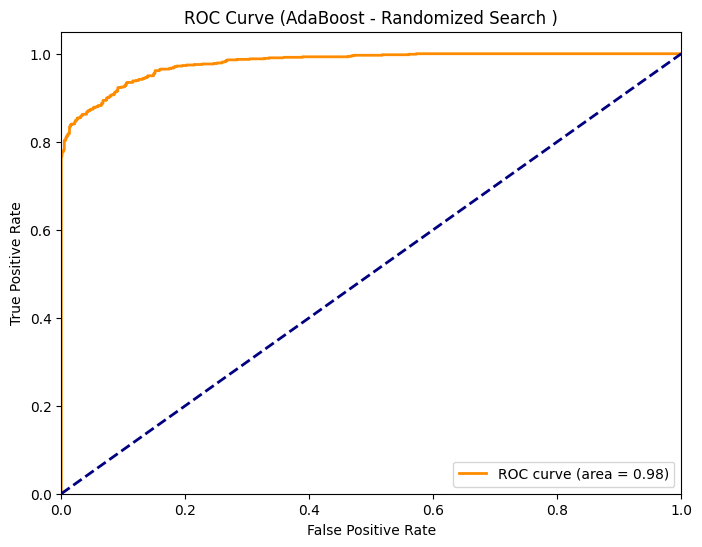

In [ ]:

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_adaboost_extended, tpr_adaboost_extended, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_adaboost_extended)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost - Randomized Search )')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()

In [60]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define the LGBM model
lgbm_model = LGBMClassifier()

# Fit the model on the training data
lgbm_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 3368, number of negative: 3393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 6761, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498151 -> initscore=-0.007395
[LightGBM] [Info] Start training from score -0.007395


LGBMClassifier()

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       833
           1       0.98      0.97      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy: 0.97279716
Confusion Matrix:
[[816  17]
 [ 29 829]]


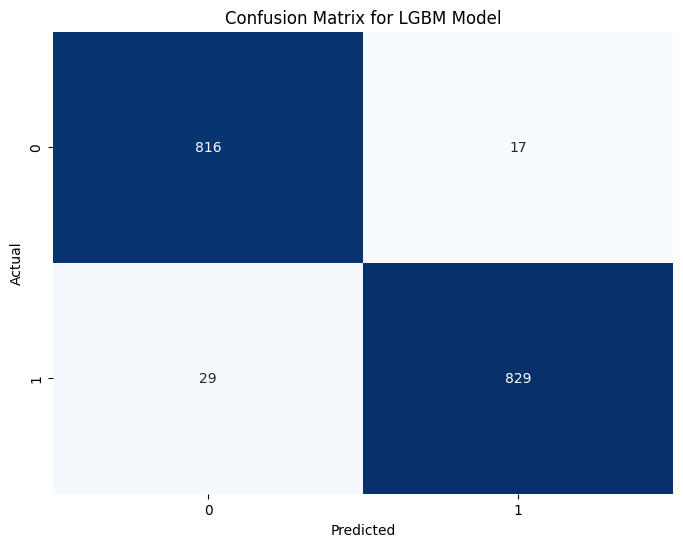

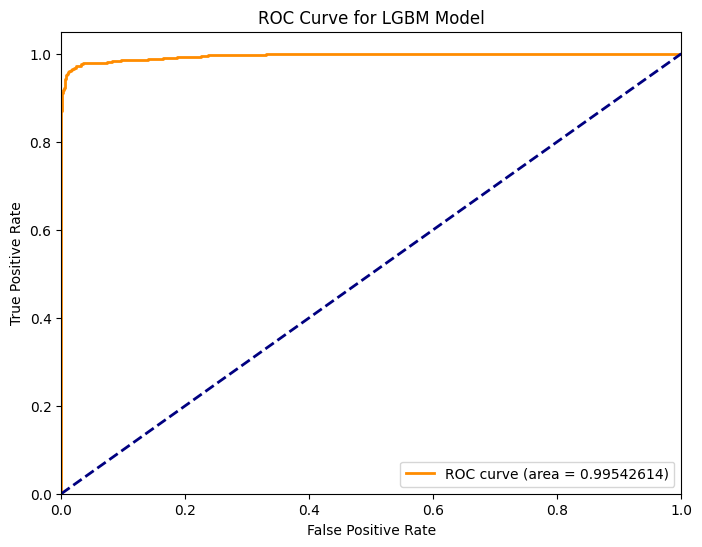

In [ ]:
# Make predictions on the test set
y_pred_lgbm = lgbm_model.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Accuracy score
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("Test Accuracy: {:.8f}".format(accuracy_lgbm))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Confusion Matrix:")
print(conf_mat_lgbm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for LGBM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
prob_predictions_lgbm = lgbm_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, prob_predictions_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_lgbm))  # Adjust the number of decimal places
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LGBM Model')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3368, number of negative: 3393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1740
[LightGBM] [Info] Number of data points in the train set: 6761, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498151 -> initscore=-0.007395
[LightGBM] [Info] Start training from score -0.007395
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
Best Accuracy: 0.97322912
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly 

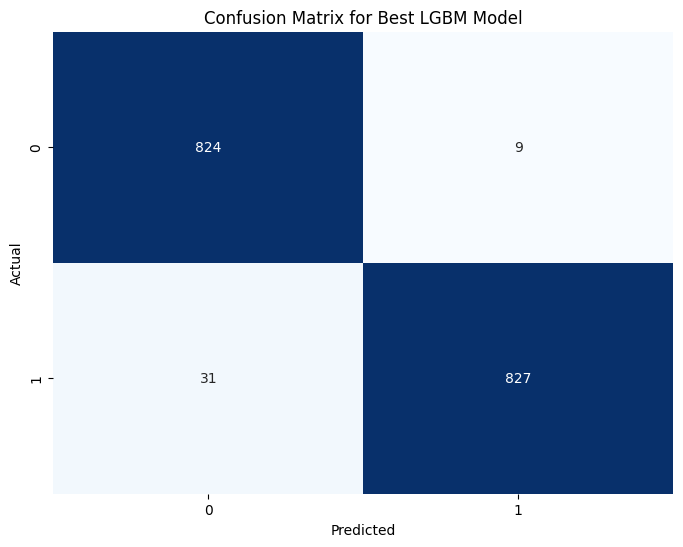

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


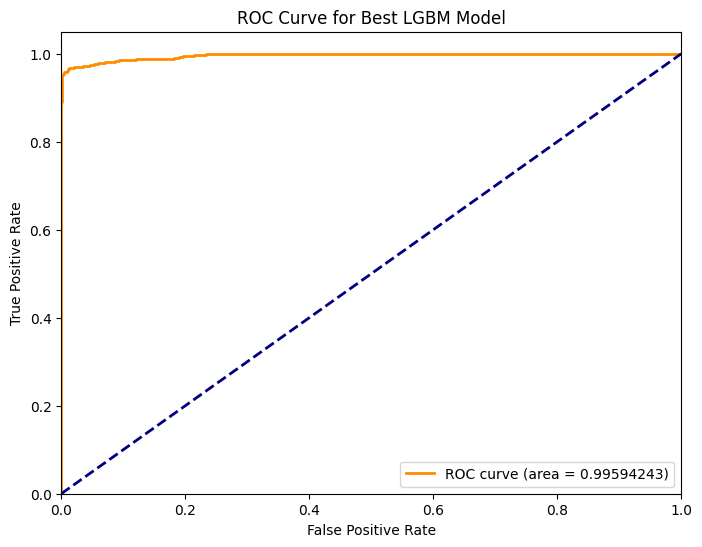

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define the LGBM model
lgbm_model = LGBMClassifier()

# Define the parameter grid for grid search
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 1, 2],
    'reg_lambda': [0, 1, 2]
}

# Create a GridSearchCV object
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, scoring='accuracy', cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search_lgbm.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Best Accuracy: {:.8f}".format(grid_search_lgbm.best_score_))  # Adjust the number of decimal places

# Get the best model from grid search
best_lgbm_model = grid_search_lgbm.best_estimator_

# Evaluate the best model on the test set
y_pred_best_lgbm = best_lgbm_model.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_best_lgbm))
accuracy_best_lgbm = accuracy_score(y_test, y_pred_best_lgbm)
print("Test Accuracy: {:.8f}".format(accuracy_best_lgbm))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_best_lgbm = confusion_matrix(y_test, y_pred_best_lgbm)
print("Confusion Matrix:")
print(conf_mat_best_lgbm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_best_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Best LGBM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
prob_predictions_best_lgbm = best_lgbm_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_best_lgbm, tpr_best_lgbm, _ = roc_curve(y_test, prob_predictions_best_lgbm)
roc_auc_best_lgbm = auc(fpr_best_lgbm, tpr_best_lgbm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_best_lgbm, tpr_best_lgbm, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_best_lgbm))  # Adjust the number of decimal places
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best LGBM Model')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


[LightGBM] [Info] Number of positive: 3368, number of negative: 3393
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1740
[LightGBM] [Info] Number of data points in the train set: 6761, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498151 -> initscore=-0.007395
[LightGBM] [Info] Start training from score -0.007395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

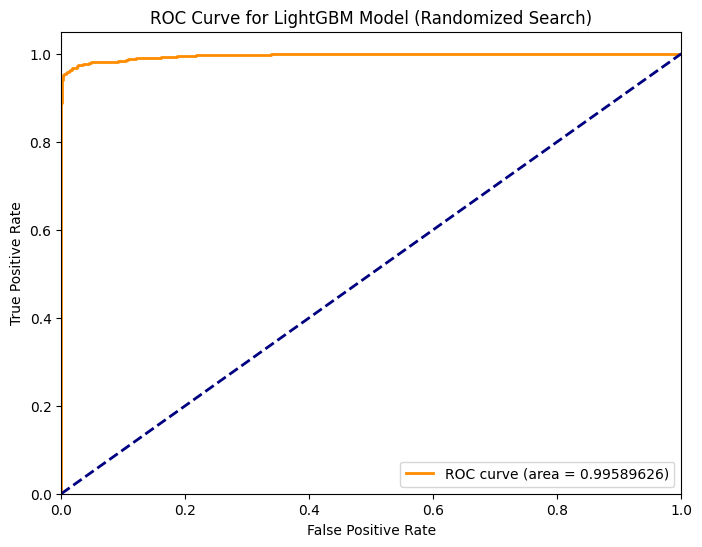

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define the LightGBM model
lgbm_model = LGBMClassifier()

# Define the parameter grid for randomized search
param_dist_lgbm = {
    'n_estimators': np.arange(50, 201, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 12),
    'num_leaves': np.arange(10, 51),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 5, 10]
}

# Create a RandomizedSearchCV object
random_search_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_dist_lgbm,
                                         scoring='accuracy', cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Perform randomized search on the training data
random_search_lgbm.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", random_search_lgbm.best_params_)
print("Best Accuracy: {:.8f}".format(random_search_lgbm.best_score_))  # Adjust the number of decimal places

# Get the best model from randomized search
best_lgbm_model_random = random_search_lgbm.best_estimator_

# Evaluate the best model on the test set
y_pred_best_lgbm_random = best_lgbm_model_random.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_best_lgbm_random))
accuracy_best_lgbm_random = accuracy_score(y_test, y_pred_best_lgbm_random)
print("Test Accuracy: {:.8f}".format(accuracy_best_lgbm_random))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_lgbm_random = confusion_matrix(y_test, y_pred_best_lgbm_random)
print("Confusion Matrix:")
print(conf_mat_lgbm_random)

# ROC Curve
prob_predictions_lgbm_random = best_lgbm_model_random.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_lgbm_random, tpr_lgbm_random, _ = roc_curve(y_test, prob_predictions_lgbm_random)
roc_auc_lgbm_random = auc(fpr_lgbm_random, tpr_lgbm_random)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_lgbm_random, tpr_lgbm_random, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_lgbm_random))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model (Randomized Search)')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


In [61]:
from sklearn.ensemble import VotingClassifier

In [62]:
svm = SVC()
LR = LogisticRegression()
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=3)

In [63]:
models = [('SVM',svm),('Decision Tree',tree),('Logistic Regerssion',LR) , ('KNN',knn)]

voting_model = VotingClassifier(
    estimators= models
)

In [64]:
voting_model.fit(x_train, y_train)

VotingClassifier(estimators=[('SVM', SVC()),
                             ('Decision Tree', DecisionTreeClassifier()),
                             ('Logistic Regerssion', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
y_pred = voting_model.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, voting_model.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       833
           1       0.94      0.94      0.94       858

    accuracy                           0.94      1691
   macro avg       0.94      0.94      0.94      1691
weighted avg       0.94      0.94      0.94      1691

Train Accuracy:  0.9507469309273776
Test Accuracy:  0.937906564163217


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       833
           1       0.93      0.98      0.95       858

    accuracy                           0.95      1691
   macro avg       0.95      0.95      0.95      1691
weighted avg       0.95      0.95      0.95      1691

Test Accuracy: 0.95209935
Confusion Matrix:
[[769  64]
 [ 17 841]]


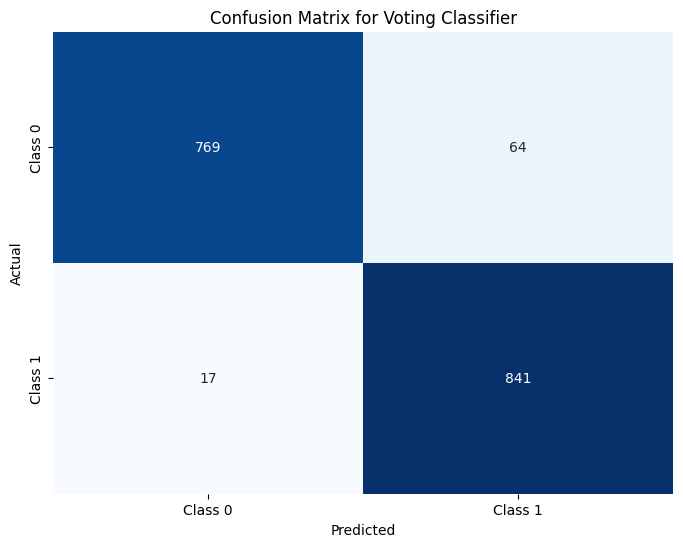

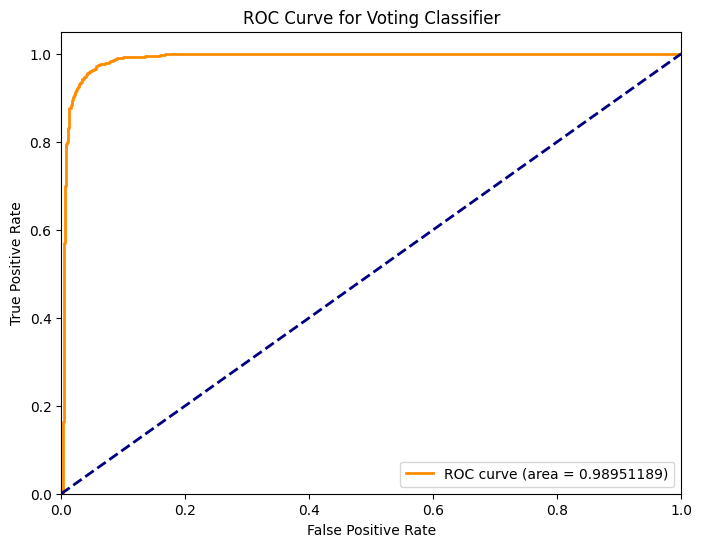

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have x_train, y_train, x_test, y_test already defined

# Define models
svm = SVC(probability=True)  # Note: probability=True for ROC curve
tree = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)

# Create a list of models
models = [('SVM', svm), ('Decision Tree', tree), ('Logistic Regression', lr), ('KNN', knn)]

# Create a Voting Classifier
voting_model = VotingClassifier(estimators=models, voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Fit the Voting Classifier on the training data
voting_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_voting = voting_model.predict(x_test)

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Test Accuracy: {:.8f}".format(accuracy_voting))  # Adjust the number of decimal places

# Confusion Matrix
conf_mat_voting = confusion_matrix(y_test, y_pred_voting)
print("Confusion Matrix:")
print(conf_mat_voting)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_voting, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title('Confusion Matrix for Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# ROC Curve
prob_predictions_voting = voting_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_voting, tpr_voting, _ = roc_curve(y_test, prob_predictions_voting)
roc_auc_voting = auc(fpr_voting, tpr_voting)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_voting, tpr_voting, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_voting))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Classifier')
plt.legend(loc='lower right')

# Display the ROC curve
plt.show()


Best Parameters: {'Decision Tree__max_depth': None, 'KNN__n_neighbors': 3, 'Logistic Regression__C': 1, 'SVM__C': 10}
Best Accuracy: 0.93092766
Test Accuracy: 0.96156121
Confusion Matrix:
[[781  52]
 [ 13 845]]


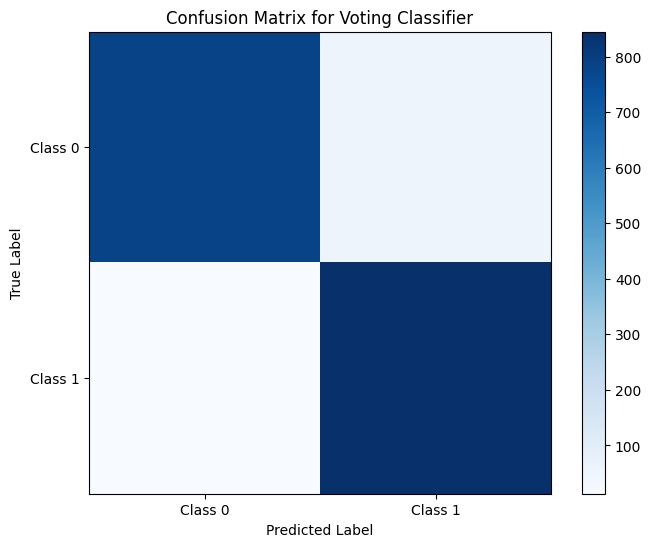

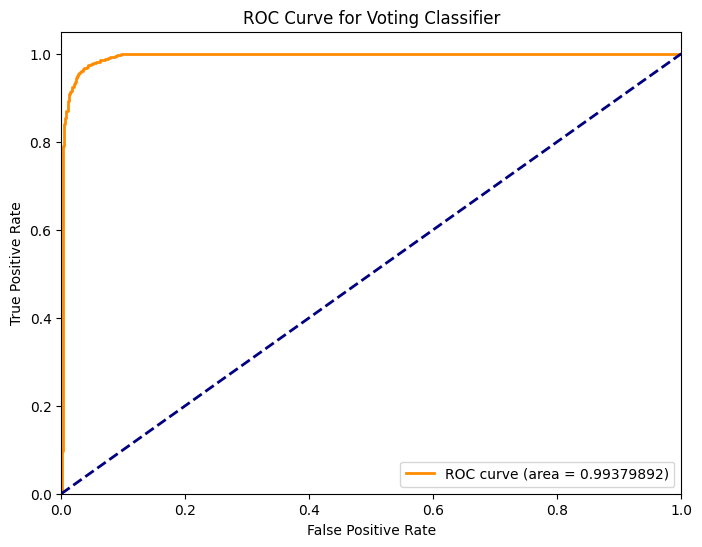

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have x_train, y_train, x_test, y_test already defined

# Define models
svm = SVC(probability=True)
tree = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)

# Create a list of models
models = [('SVM', svm), ('Decision Tree', tree), ('Logistic Regression', lr), ('KNN', knn)]

# Create a Voting Classifier
voting_model = VotingClassifier(estimators=models, voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Create a parameter grid for each classifier
param_grid = {
    'SVM__C': [1, 10],
    'Decision Tree__max_depth': [None, 5, 10],
    'Logistic Regression__C': [0.1, 1, 10],
    'KNN__n_neighbors': [3, 5, 7]
}

# Create a GridSearchCV object
grid_search_voting = GridSearchCV(estimator=voting_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search_voting.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", grid_search_voting.best_params_)
print("Best Accuracy: {:.8f}".format(grid_search_voting.best_score_))

# Get the best model from grid search
best_voting_model = grid_search_voting.best_estimator_

# Evaluate the best model on the test set
y_pred_best_voting = best_voting_model.predict(x_test)
accuracy_best_voting = accuracy_score(y_test, y_pred_best_voting)
print("Test Accuracy: {:.8f}".format(accuracy_best_voting))

# Confusion Matrix
conf_mat_best_voting = confusion_matrix(y_test, y_pred_best_voting)
print("Confusion Matrix:")
print(conf_mat_best_voting)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_best_voting, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Voting Classifier')
plt.colorbar()
plt.xticks([0, 1], ["Class 0", "Class 1"])
plt.yticks([0, 1], ["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
prob_predictions_best_voting = best_voting_model.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_best_voting, tpr_best_voting, _ = roc_curve(y_test, prob_predictions_best_voting)
roc_auc_best_voting = auc(fpr_best_voting, tpr_best_voting)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_best_voting, tpr_best_voting, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_best_voting))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Voting Classifier')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_best_voting))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       833
           1       0.94      0.98      0.96       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691



Best Parameters: {'SVM__C': 1000.0, 'Logistic Regression__C': 0.1, 'KNN__n_neighbors': 3, 'Decision Tree__max_depth': 15}
Best Accuracy: 0.93832301
Test Accuracy: 0.96392667
Confusion Matrix:
[[784  49]
 [ 12 846]]


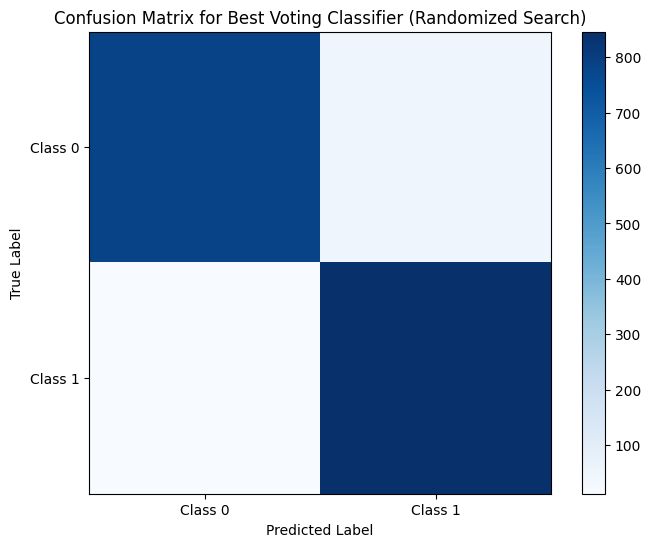

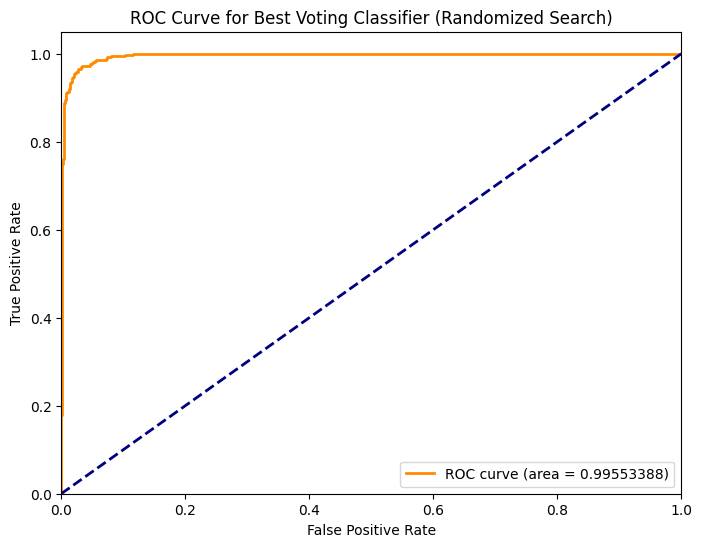

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have x_train, y_train, x_test, y_test already defined

# Define models
svm = SVC(probability=True)
tree = DecisionTreeClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=3)

# Create a list of models
models = [('SVM', svm), ('Decision Tree', tree), ('Logistic Regression', lr), ('KNN', knn)]

# Create a Voting Classifier
voting_model = VotingClassifier(estimators=models, voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Define the parameter grid for randomized search
param_dist_voting = {
    'SVM__C': np.logspace(-3, 3, 7),
    'Decision Tree__max_depth': [None] + list(np.arange(5, 20, 1)),
    'Logistic Regression__C': np.logspace(-3, 3, 7),
    'KNN__n_neighbors': [3, 5, 7, 9, 11]
}

# Create a RandomizedSearchCV object
random_search_voting = RandomizedSearchCV(estimator=voting_model, param_distributions=param_dist_voting,
                                           scoring='accuracy', cv=5, n_iter=50, n_jobs=-1, random_state=42)

# Perform randomized search on the training data
random_search_voting.fit(x_train, y_train)

# Display the best parameters and corresponding accuracy
print("Best Parameters:", random_search_voting.best_params_)
print("Best Accuracy: {:.8f}".format(random_search_voting.best_score_))

# Get the best model from randomized search
best_voting_model_random = random_search_voting.best_estimator_

# Evaluate the best model on the test set
y_pred_best_voting_random = best_voting_model_random.predict(x_test)
accuracy_best_voting_random = accuracy_score(y_test, y_pred_best_voting_random)
print("Test Accuracy: {:.8f}".format(accuracy_best_voting_random))

# Confusion Matrix
conf_mat_best_voting_random = confusion_matrix(y_test, y_pred_best_voting_random)
print("Confusion Matrix:")
print(conf_mat_best_voting_random)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_best_voting_random, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best Voting Classifier (Randomized Search)')
plt.colorbar()
plt.xticks([0, 1], ["Class 0", "Class 1"])
plt.yticks([0, 1], ["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
prob_predictions_best_voting_random = best_voting_model_random.predict_proba(x_test)[:, 1]  # Use probability scores for class 1

# Calculate ROC curve
fpr_best_voting_random, tpr_best_voting_random, _ = roc_curve(y_test, prob_predictions_best_voting_random)
roc_auc_best_voting_random = auc(fpr_best_voting_random, tpr_best_voting_random)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_best_voting_random, tpr_best_voting_random, color='darkorange', lw=lw, label='ROC curve (area = {:.8f})'.format(roc_auc_best_voting_random))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Voting Classifier (Randomized Search)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_best_voting_random))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       833
           1       0.95      0.99      0.97       858

    accuracy                           0.96      1691
   macro avg       0.97      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691



In [73]:
base_models = [('Decision Tree',DecisionTreeClassifier()),('Logistic Regerssion',LogisticRegression()),('KNN', KNeighborsClassifier(n_neighbors=3))]
stacking = StackingClassifier(
    estimators = base_models ,
    final_estimator = LogisticRegression(),
    cv = 7
)

stacking.fit(x_train , y_train)

StackingClassifier(cv=7,
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Logistic Regerssion', LogisticRegression()),
                               ('KNN', KNeighborsClassifier(n_neighbors=3))],
                   final_estimator=LogisticRegression())

In [74]:
y_pred = stacking.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, stacking.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       833
           1       0.95      0.98      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Train Accuracy:  0.9995562786570034
Test Accuracy:  0.9662921348314607


In [75]:
base_models = [('Decision Tree',DecisionTreeClassifier()),('Logistic Regerssion',LogisticRegression()) , ('KNN',KNeighborsClassifier(n_neighbors=3))]
stacking = StackingClassifier(
    estimators = base_models ,
    final_estimator = LogisticRegression(),
    cv = 5
)

stacking.fit(x_train , y_train)

StackingClassifier(cv=5,
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Logistic Regerssion', LogisticRegression()),
                               ('KNN', KNeighborsClassifier(n_neighbors=3))],
                   final_estimator=LogisticRegression())

In [76]:
y_pred = stacking.predict(x_test)
accuracy_score(y_test,y_pred)

0.9668835008870491

Cross Validation Score: 98.04%


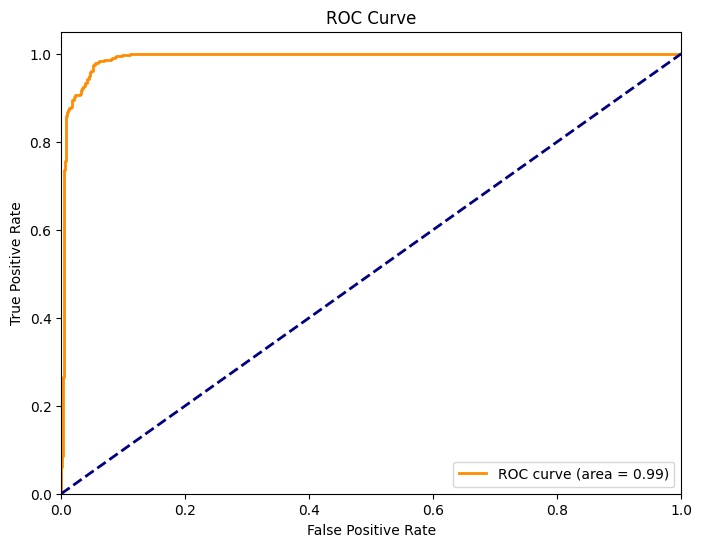

In [ ]:
model(stacking,x_train,y_train,x_test,y_test)


Best Hyperparameters for Stacking Classifier: {'cv': 7, 'final_estimator__C': 100, 'final_estimator__class_weight': 'balanced', 'final_estimator__dual': False, 'final_estimator__max_iter': 50, 'final_estimator__penalty': 'l1', 'final_estimator__solver': 'liblinear', 'passthrough': False, 'stack_method': 'auto'}
Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       833
           1       0.95      0.98      0.97       858

    accuracy                           0.96      1691
   macro avg       0.96      0.96      0.96      1691
weighted avg       0.96      0.96      0.96      1691

Test Accuracy for Stacking Classifier:  0.9639266706091071
Confusion Matrix for Stacking Classifier:
 [[788  45]
 [ 16 842]]


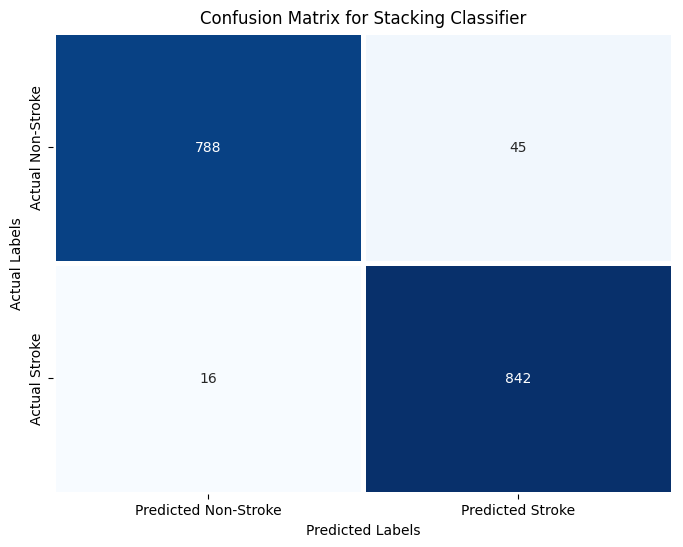

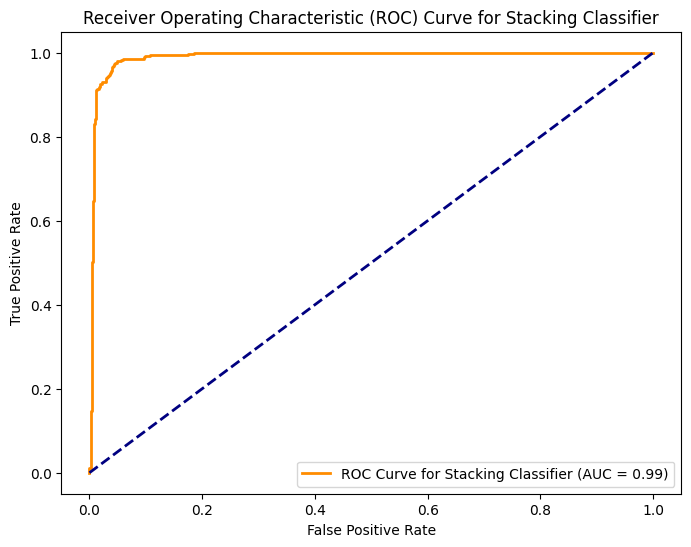

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base models
base_models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=3))
]

# Create the stacking classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=7
)

# Define the hyperparameter grid for the grid search
param_grid = {
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'stack_method': ['auto', 'predict_proba'],  # Stacking method
    'passthrough': [True, False],  # Passthrough option
    'cv': [5, 7, 10],  # Number of folds for cross-validation
    'final_estimator__solver': ['liblinear', 'saga'],  # Solver for the logistic regression
    'final_estimator__max_iter': [50, 100, 200],  # Maximum number of iterations for logistic regression
    'final_estimator__class_weight': [None, 'balanced'],  # Class weight for logistic regression
    'final_estimator__dual': [False],  # Dual parameter for logistic regression
    # Add other hyperparameters specific to the final estimator or the stacking classifier
}

# Create the GridSearchCV object
grid_search_stacking = GridSearchCV(stacking, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
grid_search_stacking.fit(x_train, y_train)

# Get the best hyperparameters
best_params_stacking = grid_search_stacking.best_params_
print("Best Hyperparameters for Stacking Classifier:", best_params_stacking)

# Get the best model
best_stacking_model = grid_search_stacking.best_estimator_

# Make predictions on the test set using the best model
y_pred_stacking = best_stacking_model.predict(x_test)

# Print classification report and accuracy scores for the Stacking Classifier
print("Classification Report for Stacking Classifier:\n", classification_report(y_test, y_pred_stacking))
print("Test Accuracy for Stacking Classifier: ", accuracy_score(y_test, y_pred_stacking))

# Confusion Matrix for Stacking Classifier
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
print("Confusion Matrix for Stacking Classifier:\n", conf_matrix_stacking)

# Plot Confusion Matrix for Stacking Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Stacking Classifier')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve for Stacking Classifier
y_prob_stacking = best_stacking_model.predict_proba(x_test)[:, 1]
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_prob_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plot ROC Curve for Stacking Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label=f'ROC Curve for Stacking Classifier (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Classifier')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters for Stacking Classifier: {'cv': 10, 'final_estimator__C': 1, 'final_estimator__max_iter': 200, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'saga', 'passthrough': False, 'stack_method': 'auto'}
Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       833
           1       0.95      0.98      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Test Accuracy for Stacking Classifier:  0.9657007687758723
Confusion Matrix for Stacking Classifier:
 [[790  43]
 [ 15 843]]


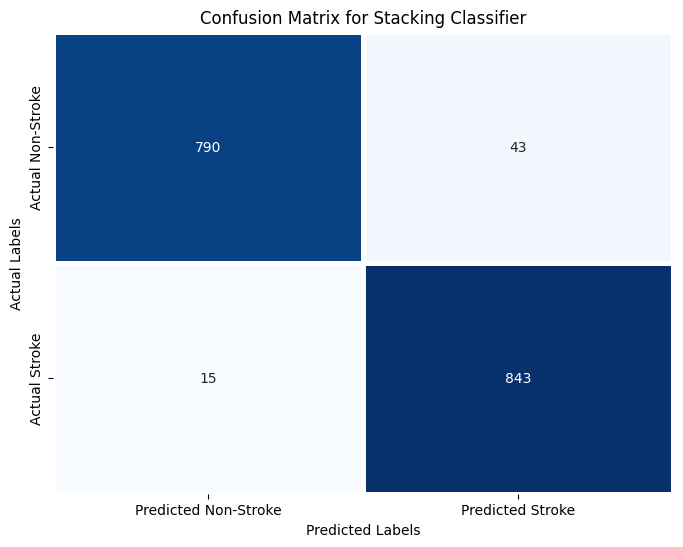

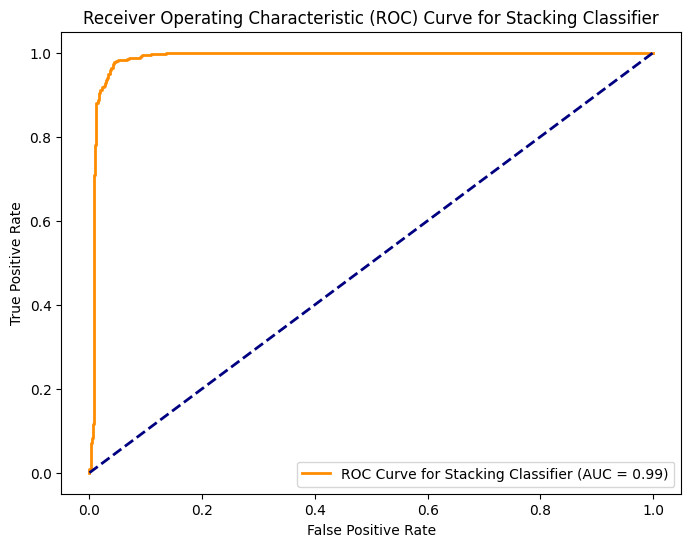

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base models
base_models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=3))
]

# Create the stacking classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=7
)

# Define the hyperparameter grid for the grid search
param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'saga'],
    'final_estimator__max_iter': [50, 100, 200],
    'stack_method': stacking_methods,
    'passthrough': [True, False],
    'cv': [5, 7, 10]
}


# Create the GridSearchCV object
grid_search_stacking = GridSearchCV(stacking, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search to the data
grid_search_stacking.fit(x_train, y_train)

# Get the best hyperparameters
best_params_stacking = grid_search_stacking.best_params_
print("Best Hyperparameters for Stacking Classifier:", best_params_stacking)

# Get the best model
best_stacking_model = grid_search_stacking.best_estimator_

# Make predictions on the test set using the best model
y_pred_stacking = best_stacking_model.predict(x_test)

# Print classification report and accuracy scores for the Stacking Classifier
print("Classification Report for Stacking Classifier:\n", classification_report(y_test, y_pred_stacking))
print("Test Accuracy for Stacking Classifier: ", accuracy_score(y_test, y_pred_stacking))

# Confusion Matrix for Stacking Classifier
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
print("Confusion Matrix for Stacking Classifier:\n", conf_matrix_stacking)

# Plot Confusion Matrix for Stacking Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Stacking Classifier')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve for Stacking Classifier
y_prob_stacking = best_stacking_model.predict_proba(x_test)[:, 1]
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_prob_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plot ROC Curve for Stacking Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label=f'ROC Curve for Stacking Classifier (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Classifier')
plt.legend(loc="lower right")
plt.show()


In [ ]:

from sklearn.model_selection import GridSearchCV

# Define base estimators
base_models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
]

# Create stacking classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5,
)


# Define hyperparameter grids for base estimators
param_grid_rf = {
    'Decision Tree__max_depth': [2, 3, 5, 10, 20],
    'Decision Tree__min_samples_leaf': [5, 10, 20, 50, 100],
    'Decision Tree__max_features': ['auto', 'sqrt', 'log2'],
    'Decision Tree__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'Decision Tree__splitter': ['best', 'random'],
}

param_grid_lr = {
    'Logistic Regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'Logistic Regression__solver': ['lbfgs', 'sag', 'newton-cg'],
    'Logistic Regression__penalty': ['l1', 'l2'],
}

param_grid_knn = {
    'KNN__n_neighbors': [3, 5, 7, 9, 11],
    'KNN__metric': ['minkowski', 'euclidean', 'manhattan'],
    'KNN__weights': ['uniform', 'distance'],
}


# Create hyperparameter grid for meta-estimator
param_grid_meta = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Combine hyperparameter grids
param_grid = {
    **param_grid_rf,
    **param_grid_lr,
    **param_grid_knn,
    **param_grid_meta,
}

# Perform grid search
grid_search = GridSearchCV(stacking, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Evaluate best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train final model
stacking.set_params(**best_params)
stacking.fit(x_train, y_train)

# Evaluate final model
y_pred = stacking.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_stacking))

# Accuracy score
print("Test Accuracy:", accuracy_score(y_test, y_pred_stacking))

# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_stacking))

# ROC curve
y_prob_stacking = best_stacking_model.predict_proba(x_test)[:, 1]
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_prob_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2,
         label=f'ROC Curve for Stacking Classifier (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, LogisticRegression, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the base models
base_models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
]

# Define the final estimator
final_estimator = LogisticRegression()

# Define the stacking classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=final_estimator,
    stack_method='predict', # Changed stack_method from 'vote' to 'predict'
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
)

# Define a custom scoring function for ROC AUC
roc_auc_scorer = make_scorer(roc_auc, greater_is_better=True)

# Define hyperparameter grids for base estimators
param_grid_rf = {
    'Decision Tree__max_depth': [2, 3, 5, 10, 20],
    'Decision Tree__min_samples_leaf': [5, 10, 20, 50, 100],
    'Decision Tree__max_features': ['auto', 'sqrt', 'log2'],
    'Decision Tree__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'Decision Tree__splitter': ['best', 'random'],
}

param_grid_lr = {
    'Logistic Regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'Logistic Regression__solver': ['lbfgs', 'sag', 'newton-cg'],
    'Logistic Regression__penalty': ['l1', 'l2'],
}

param_grid_knn = {
    'KNN__n_neighbors': [3, 5, 7, 9, 11],
    'KNN__metric': ['minkowski', 'euclidean', 'manhattan'],
    'KNN__weights': ['uniform', 'distance'],
}

# Combine hyperparameter grids
param_grid = {**param_grid_rf, **param_grid_lr, **param_grid_knn}

# Perform grid search with randomized search
random_search = RandomizedSearchCV(stacking, param_grid=param_grid, n_iter=100, cv=5, scoring=roc_auc_scorer, random_state=42)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters for Stacking Classifier:", best_params)

# Get the best model
best_stacking_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_stacking = best_stacking_model.predict(x_test)

# Print classification report and accuracy scores for the Stacking Classifier
print("Classification Report for Stacking Classifier:\n", classification_report(y_test, y_pred_stacking))


In [ ]:

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the base models
base_models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
]

# Define the final estimator
final_estimator = LogisticRegression()

# Define hyperparameter grids for base estimators
param_grid_rf = {
    'Decision Tree__max_depth': [2, 3, 5, 10, 20],
    'Decision Tree__min_samples_leaf': [5, 10, 20, 50, 100],
    'Decision Tree__max_features': ['auto', 'sqrt', 'log2'],
    'Decision Tree__min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'Decision Tree__splitter': ['best', 'random'],
}

param_grid_lr = {
    'Logistic Regression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'Logistic Regression__solver': ['lbfgs', 'sag', 'newton-cg'],
    'Logistic Regression__penalty': ['l1', 'l2'],
}

param_grid_knn = {
    'KNN__n_neighbors': [3, 5, 7, 9, 11],
    'KNN__metric': ['minkowski', 'euclidean', 'manhattan'],
    'KNN__weights': ['uniform', 'distance'],
}

# Combine hyperparameter grids
param_grid = {**param_grid_rf, **param_grid_lr, **param_grid_knn}

# Define hyperparameter grid for final estimator
final_estimator_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'sag', 'newton-cg'],
    'penalty': ['l1', 'l2'],
}

# Create the stacking classifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=KFold(n_splits=10, shuffle=True, random_state=42)
)

# Perform grid search with GridSearchCV
grid_search = GridSearchCV(stacking, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters for Stacking Classifier:", best_params)

# Get the best model
best_stacking_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_stacking = best_stacking_model.predict(x_test)

# Print classification report and accuracy scores for the Stacking Classifier
print("Classification Report for Stacking Classifier:\n", classification_report(y_test, y_pred_stacking))
print("Test Accuracy for Stacking Classifier: ", accuracy_score(y_test, y_pred_stacking))


In [ ]:

# Plot Confusion Matrix for Stacking Classifier
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix for Stacking Classifier')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# ROC Curve for Stacking Classifier
y_prob_stacking = best_stacking_model.predict_proba(x_test)[:, 1]
fpr_stacking, tpr_stacking, thresholds_stacking = roc_curve(y_test, y_prob_stacking)
roc_auc_stacking = auc(fpr_stacking, tpr_stacking)

# Plot ROC Curve for Stacking Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label=f'ROC Curve for Stacking Classifier (AUC = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Classifier')
plt.legend(loc="lower right")
plt.show()


In [ ]:
y= df['stroke']
X = df.drop('stroke', axis=1)
categorical = [ 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
numerical = ['avg_glucose_level', 'bmi','age']

model =rf_regr#LogisticRegression(solver='liblinear')

transformer = ColumnTransformer(transformers=[('imp',SimpleImputer(strategy='median'),numerical),('o',OneHotEncoder(),categorical)])

pipeline = Pipeline(steps=[('t', transformer),('p',PowerTransformer(method='yeo-johnson')),('m', model)])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

result = cross_val_score(pipeline, X, y,  scoring='accuracy',cv=cv, n_jobs=-1)

print(f'{round(np.mean(result),5)}')

0.95567


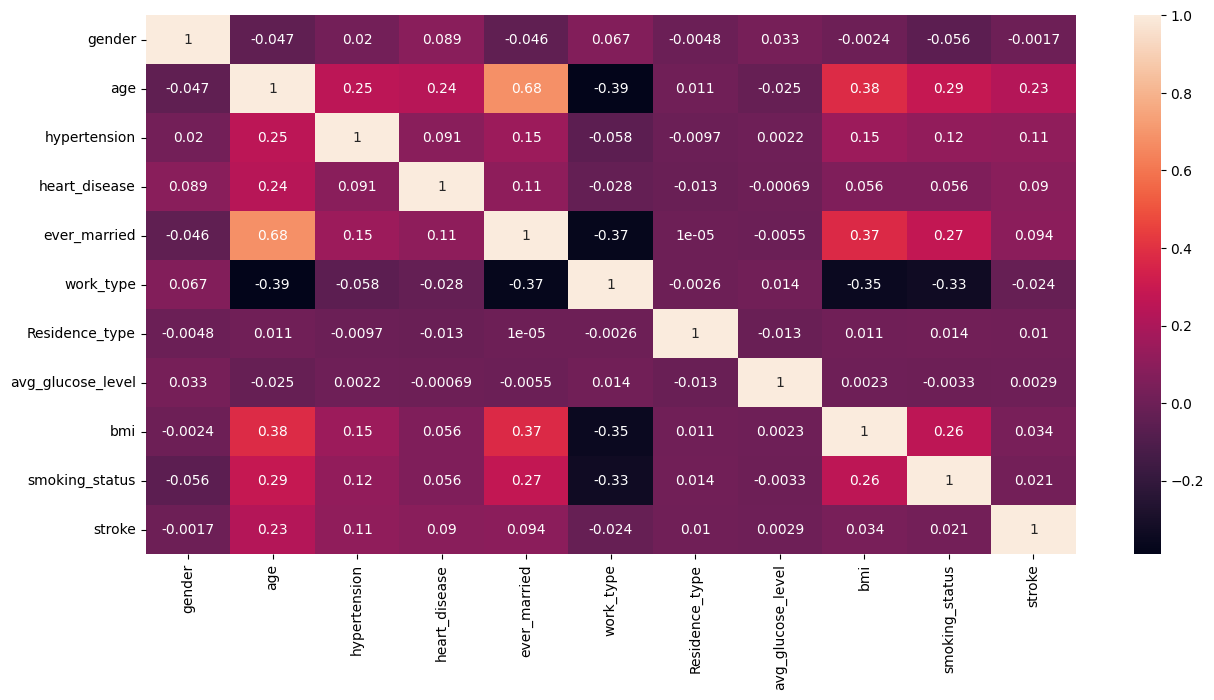

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True);

In [77]:
from sklearn.naive_bayes import GaussianNB
gnb= GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(x_test)

print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, gnb.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       833
           1       0.79      0.79      0.79       858

    accuracy                           0.78      1691
   macro avg       0.78      0.78      0.78      1691
weighted avg       0.78      0.78      0.78      1691

Train Accuracy:  0.7649755953261352
Test Accuracy:  0.7847427557658191


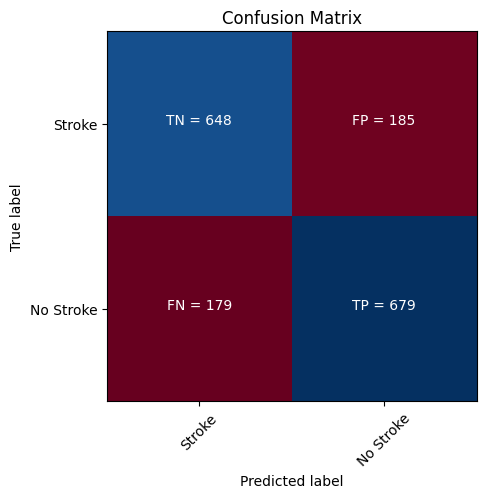

In [ ]:
#Make Plots
plot_cm(gnb, gnb.predict(x_test).round())


Cross Validation Score: 83.45%


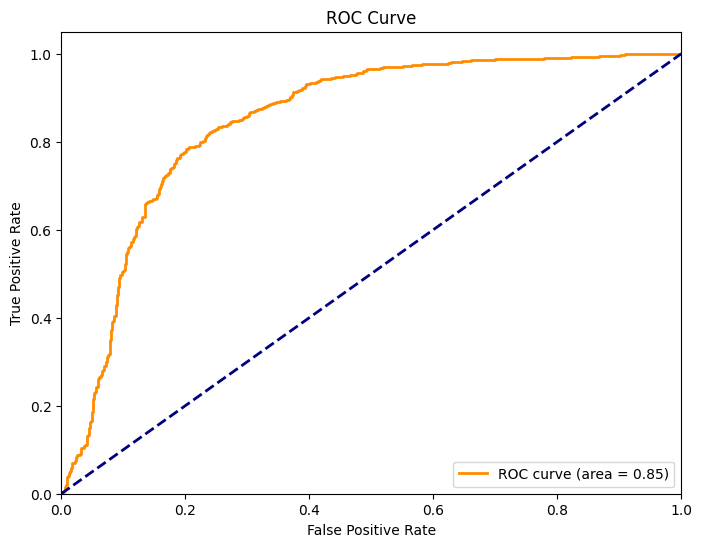

In [ ]:
model(gnb,x_train,y_train,x_test,y_test)

Best Parameters: {'priors': None, 'var_smoothing': 1e-09}
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       833
           1       0.79      0.84      0.81       858

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691

Confusion Matrix:
 [[647 186]
 [141 717]]
Confusion Matrix:
 [[647 186]
 [141 717]]


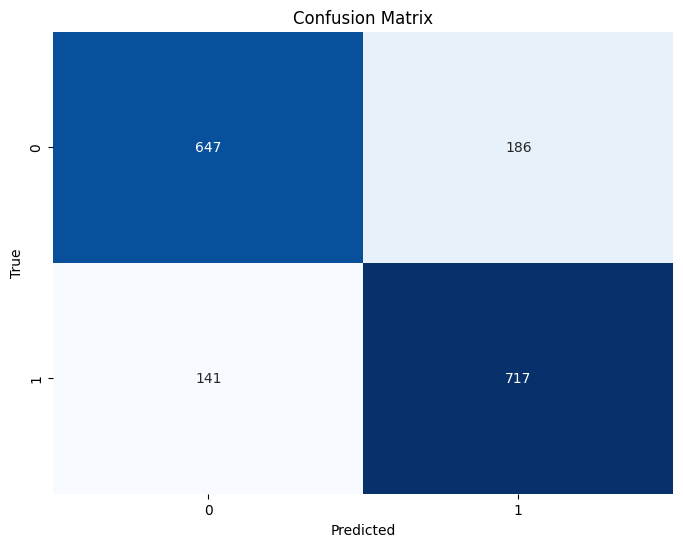

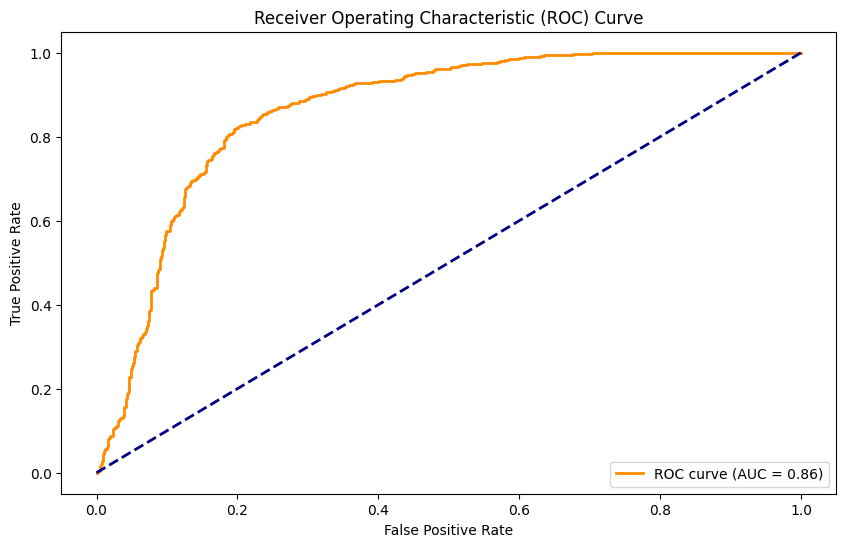

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming you have your data loaded and split into x_train, x_test, y_train, y_test

# Define the Gaussian Naive Bayes model
gnb = GaussianNB()

# Define the parameter grid you want to search
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'priors': [None, [0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(x_test)

# Generate classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Best Parameters:", best_params)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
y_probs = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       833
           1       0.79      0.85      0.82       858

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691

Confusion Matrix:
 [[639 194]
 [130 728]]


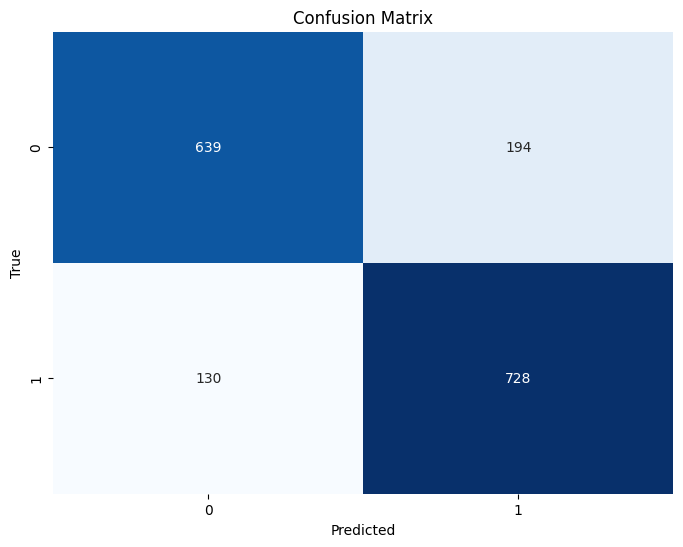

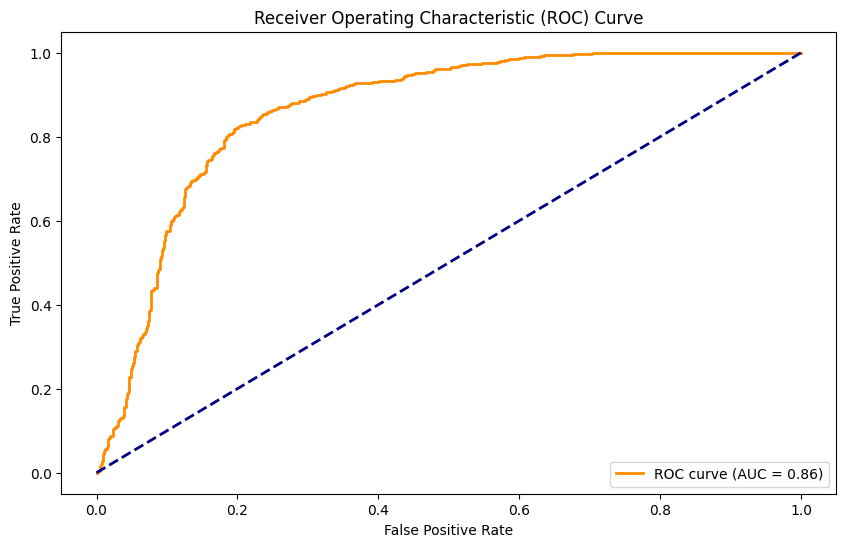

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have your data loaded with additional features (X) and labels (y)
# For simplicity, let's assume you have already split your data into training and testing sets: X_train, X_test, y_train, y_test

# Define the Gaussian Naive Bayes model
gnb = GaussianNB()

# Define the parameter distributions for Randomized Search
param_dist = {
    'var_smoothing': np.logspace(-10, -5, 100),
    'priors': [None] + [np.random.dirichlet(np.ones(2)) for _ in range(10)]  # Random priors
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gnb, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model to the training data
random_search.fit(x_train, y_train)

# Get the best parameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(x_test)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

# Generate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
y_probs = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.ensemble import StackingClassifier

# Define a list of base classifiers with associated names
models = [
    ("DecisionTree", tree_model),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ("NaiveBayes", gnb),
    ("SupportVector", svm),
    ("LogisticRegression", lr_model),
    ("RandomForest", rf_regr)
]

# Create a StackingClassifier with cross-validated stacking and a final estimator
stc_clf = StackingClassifier(estimators=models, final_estimator=lr_model, cv=7)

# Fit the StackingClassifier on the training data
stc_clf.fit(x_train, y_train)


StackingClassifier(cv=7,
                   estimators=[('DecisionTree', DecisionTreeClassifier()),
                               ('KNN', KNeighborsClassifier(n_neighbors=3)),
                               ('NaiveBayes', GaussianNB()),
                               ('SupportVector', SVC()),
                               ('LogisticRegression', LogisticRegression()),
                               ('RandomForest',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=5,
                                                       random_state=123))],
                   final_estimator=LogisticRegression())

In [ ]:
y_pred = stc_clf.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, stc_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       833
           1       0.98      0.98      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Train Accuracy:  0.9989646501996746
Test Accuracy:  0.9775280898876404


In [ ]:
y_pred = stc_clf.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, stc_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       833
           1       0.98      0.98      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Train Accuracy:  0.9994083715426711
Test Accuracy:  0.9775280898876404


In [98]:
from sklearn.ensemble import StackingClassifier

# Define a list of base classifiers with associated names
models = [
    #("DecisionTree", tree_model),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    #("NaiveBayes", gnb),
    ("SupportVector", svm),
    ("LogisticRegression", lr_model),
    ("RandomForest", rf_regr)
]

# Create a StackingClassifier with cross-validated stacking and a final estimator
stc_clf = StackingClassifier(estimators=models, final_estimator=lr_model, cv=7)

# Fit the StackingClassifier on the training data
stc_clf.fit(x_train, y_train)


StackingClassifier(cv=7,
                   estimators=[('KNN', KNeighborsClassifier(n_neighbors=3)),
                               ('SupportVector', SVC()),
                               ('LogisticRegression', LogisticRegression()),
                               ('RandomForest',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=5,
                                                       random_state=123))],
                   final_estimator=LogisticRegression())

In [99]:
y_pred = stc_clf.predict(x_test)
print(classification_report(y_test, y_pred))
print("Train Accuracy: ", accuracy_score(y_train, stc_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       833
           1       0.98      0.97      0.97       858

    accuracy                           0.97      1691
   macro avg       0.97      0.97      0.97      1691
weighted avg       0.97      0.97      0.97      1691

Train Accuracy:  0.997781393285017
Test Accuracy:  0.9727971614429332


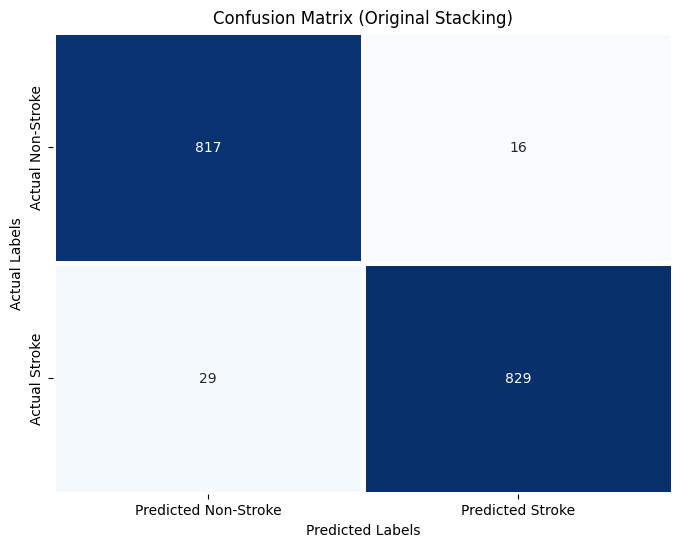

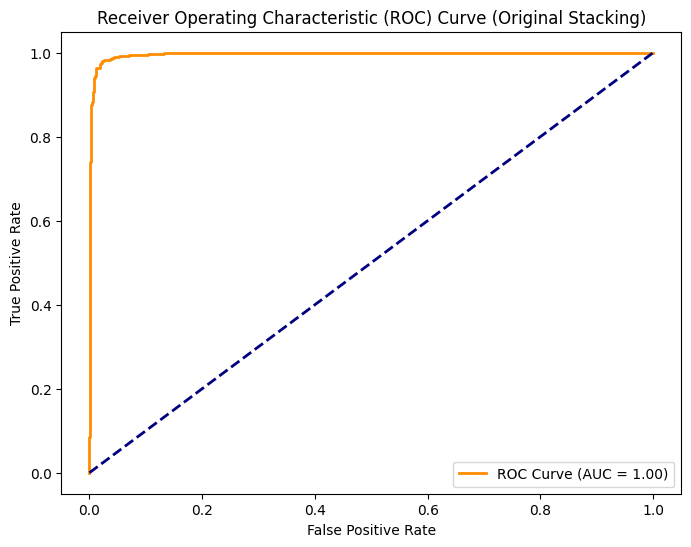

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
y_pred_stc = stc_clf.predict(x_test)
y_prob_stc = stc_clf.predict_proba(x_test)[:, 1]



# Plot Confusion Matrix
conf_matrix_stc = confusion_matrix(y_test, y_pred_stc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stc, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Original Stacking)')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

# Plot ROC Curve
fpr_stc, tpr_stc, thresholds_stc = roc_curve(y_test, y_prob_stc)
roc_auc_stc = auc(fpr_stc, tpr_stc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_stc, tpr_stc, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_stc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Original Stacking)')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define a list of base classifiers with associated names
base_models = [
    #("DecisionTree", DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    #("NaiveBayes", GaussianNB()),
    ("SupportVector", SVC()),
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier())
]

# Create a StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Define the parameter grid for grid search
param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Hyperparameter for Logistic Regression final estimator
    'stack_method': ['auto', 'predict_proba']  # Method used to train the final estimator with the stacked features
}

# Create a grid search object
grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_stacking_clf = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_stacking = best_stacking_clf.predict(x_test)

# Print the results
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_stacking))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))


In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define a list of base classifiers with associated names
base_models = [
    ("DecisionTree", DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ("NaiveBayes", GaussianNB()),
    ("SupportVector", SVC()),
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier())
]

# Create a StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Define the parameter grid for grid search
param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Hyperparameter for Logistic Regression final estimator
    'stack_method': ['auto', 'predict_proba']  # Method used to train the final estimator with the stacked features
}

# Create a grid search object
grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_stacking_clf = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_stacking = best_stacking_clf.predict(x_test)

# Print the results
print("Best Parameters:", best_params)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_stacking))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))


KeyboardInterrupt: 

In [ ]:

# Print the results
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))
print("Train Accuracy: ", accuracy_score(y_train, best_stacking_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_stacking))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       833
           1       0.99      0.98      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Train Accuracy:  1.0
Test Accuracy:  0.9828503843879361



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       833
           1       0.99      0.97      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Train Accuracy:  1.0
Test Accuracy:  0.9798935541099941
Best Hyperparameters: {'DecisionTree__max_depth': 30, 'RandomForest__n_estimators': 100, 'final_estimator__C': 10, 'stack_method': 'auto'}

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       833
           1       0.99      0.97      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691



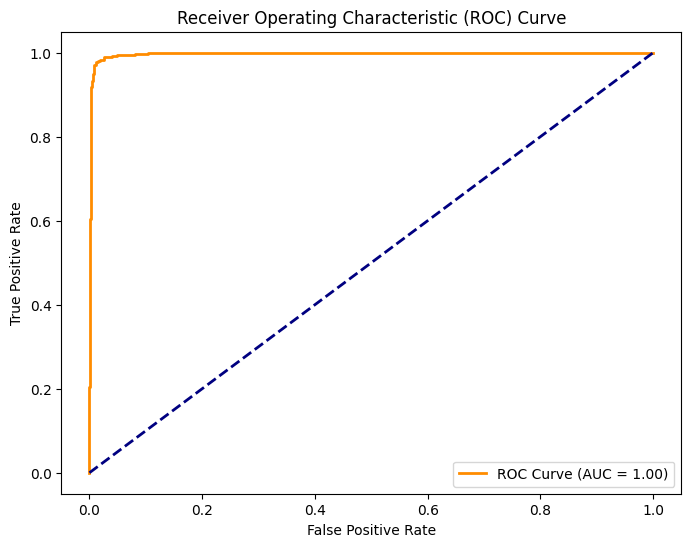

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define a list of base classifiers with associated names
base_models = [
    ("DecisionTree", DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ("NaiveBayes", GaussianNB()),
    ("SupportVector", SVC()),
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier())
]

# Create a StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Define the parameter grid for grid search
param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Hyperparameter for Logistic Regression final estimator
    'stack_method': ['auto', 'predict_proba'],  # Method used to train the final estimator with the stacked features
    'DecisionTree__max_depth': [None, 10, 20, 30],
    'RandomForest__n_estimators': [50, 100, 200]
}

# Create a grid search object
grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_stacking_clf = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred_stacking = best_stacking_clf.predict(x_test)

# Print the results
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))
print("Train Accuracy: ", accuracy_score(y_train, best_stacking_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_stacking))
print("Best Hyperparameters:", best_params)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
y_pred_stacking = best_stacking_clf.predict(x_test)
y_prob_stacking = best_stacking_clf.predict_proba(x_test)[:, 1]

# Print the Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


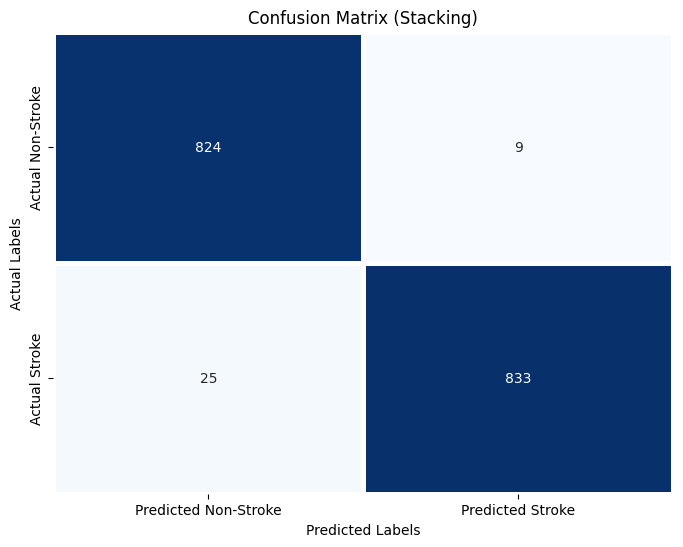

In [ ]:
# Confusion Matrix
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt="d", cmap='Blues', linewidths=2.5, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix (Stacking)')
plt.xticks([0.5, 1.5], ['Predicted Non-Stroke', 'Predicted Stroke'])
plt.yticks([0.5, 1.5], ['Actual Non-Stroke', 'Actual Stroke'])
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define a list of base classifiers with associated names
base_models = [
    ("DecisionTree", DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ("NaiveBayes", GaussianNB()),
    ("SupportVector", SVC()),
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier())
]

# Create a StackingClassifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Define the parameter distribution for random search
param_dist = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Hyperparameter for Logistic Regression final estimator
    'stack_method': ['auto', 'predict_proba']  # Method used to train the final estimator with the stacked features
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=stacking_clf, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_stacking_clf = random_search.best_estimator_

# Evaluate the model on the test set
y_pred_stacking = best_stacking_clf.predict(x_test)

# Print the results
print("\nClassification Report:\n", classification_report(y_test, y_pred_stacking))
print("Train Accuracy: ", accuracy_score(y_train, best_stacking_clf.predict(x_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_stacking))
print("Best Hyperparameters:", best_params)



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       833
           1       0.99      0.97      0.98       858

    accuracy                           0.98      1691
   macro avg       0.98      0.98      0.98      1691
weighted avg       0.98      0.98      0.98      1691

Train Accuracy:  0.9998520928856678
Test Accuracy:  0.9804849201655825
Best Hyperparameters: {'stack_method': 'auto', 'final_estimator__C': 100}


In [ ]:
pip install lime


In [ ]:
!pip install shap


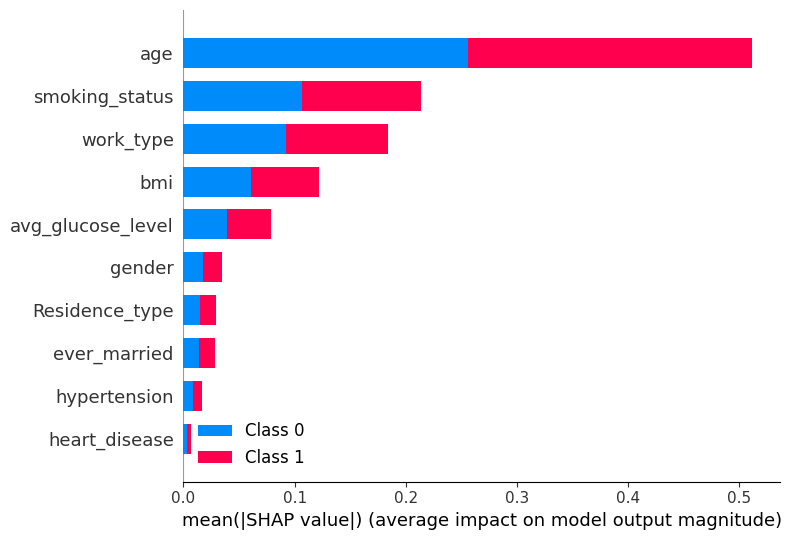

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(n_neighbors=3)

In [ ]:
import shap
import pandas as pd
from sklearn.ensemble import StackingClassifier

# ... (Previous code)

# Get the column names from the original dataset
feature_names = df.columns[:-1]  # Assuming the last column is the target variable

# Ensure x_test is a DataFrame
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Use SHAP with each base model individually
for base_model in base_models:
    explainer = shap.Explainer(base_model)
    shap_values = explainer.shap_values(x_test_df)

    # Plot summary plot or any other SHAP plots as needed
    shap.summary_plot(shap_values, x_test_df)


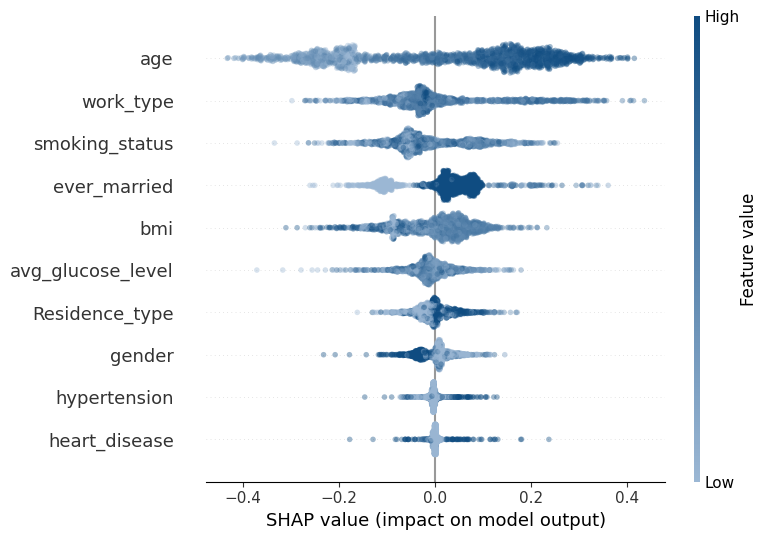

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas library

# Convert NumPy array to DataFrame
x_test_df = pd.DataFrame(x_test, columns=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])

explainer = shap.TreeExplainer(rf_regr)

# Calculate SHAP values
shap_values = explainer.shap_values(x_test_df)

# Custom color plot
colors = ["#9bb7d4", "#0f4c81"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# Plot with feature names
shap.summary_plot(shap_values[1], x_test_df, feature_names=x_test_df.columns, cmap=cmap, alpha=0.4)

plt.show()


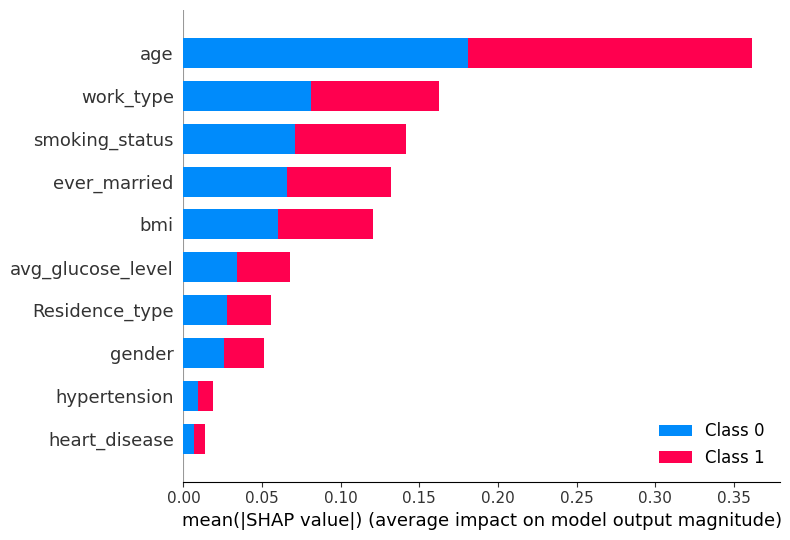

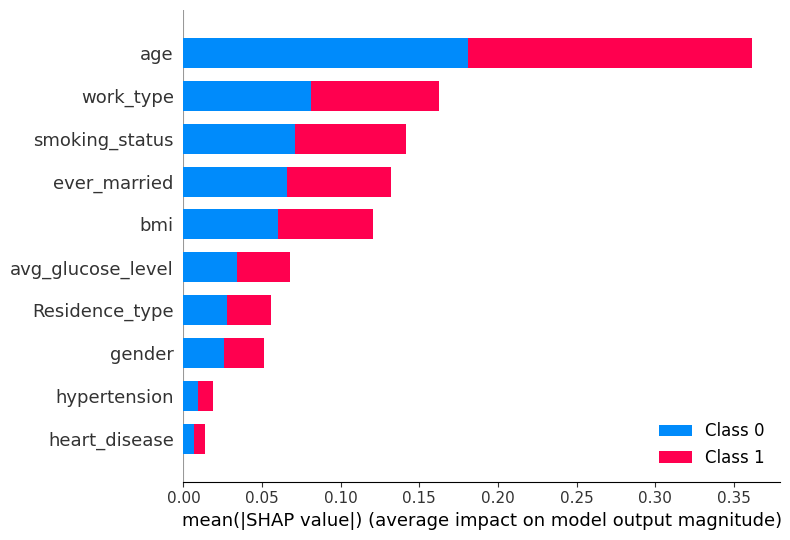

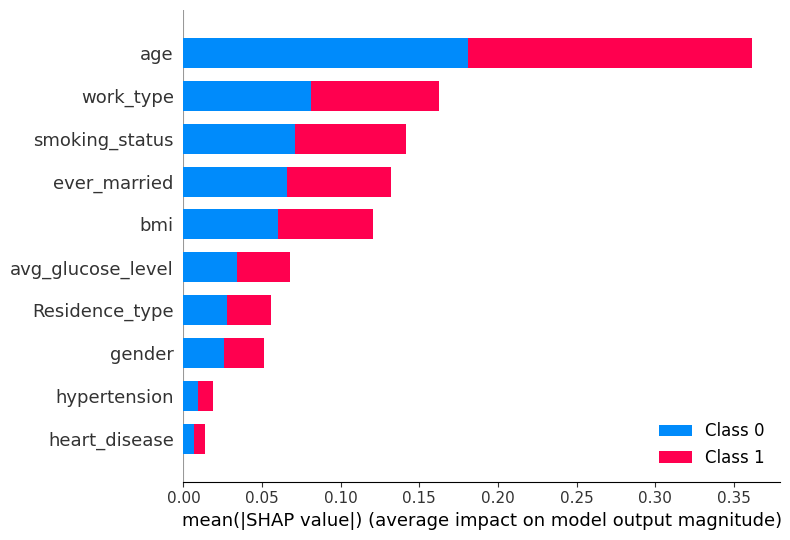

In [ ]:
import shap
import pandas as pd
from sklearn.ensemble import StackingClassifier

# ... (Previous code)

# Get the column names from the original dataset
feature_names = df.columns[:-1]  # Assuming the last column is the target variable

# Ensure x_test is a DataFrame
x_test_df = pd.DataFrame(x_test, columns=feature_names)

# Use SHAP with each base model individually
for base_model in base_models:
    explainer = shap.Explainer(rf_regr)
    shap_values = explainer.shap_values(x_test_df)

    # Plot summary plot or any other SHAP plots as needed
    shap.summary_plot(shap_values, x_test_df)


In [ ]:
pip install lime


In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model (replace this with your actual training code)
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train)

# Create a LIME explainer
explainer = LimeTabularExplainer(x_train, feature_names=x_train_df.columns.tolist(), class_names=['0', '1'], discretize_continuous=True)

# Select a specific instance for explanation
instance_idx = 0
instance = x_test[instance_idx, :]

# Explain the prediction
exp = explainer.explain_instance(instance, log_reg_model.predict_proba, num_features=len(x_train_df.columns))

# Show the explanation
exp.show_in_notebook()


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Assuming you've already trained your decision tree model:
tree_model = DecisionTreeClassifier(criterion='gini')
tree_model.fit(x_train, y_train)

# Convert NumPy array to DataFrame (if needed)
x_test_df = pd.DataFrame(x_test, columns=['gender', 'age', 'hypertension', 'heart_disease',
                                          'ever_married', 'work_type', 'Residence_type',
                                          'avg_glucose_level', 'bmi', 'smoking_status'])

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_test_df.values,  # Use DataFrame's values for LIME
    feature_names=x_test_df.columns,  # Access column names from DataFrame
    class_names=tree_model.classes_,  # Adjust for your target classes
)

# Select an instance to explain
instance_idx = 0
instance = x_test_df.iloc[instance_idx, :]

# Explain the prediction using the decision tree model's predict_proba method
exp = explainer.explain_instance(
    instance, tree_model.predict_proba, num_features=len(x_test_df.columns)
)

# Show the explanation
exp.show_in_notebook()


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime import lime_tabular
import matplotlib.pyplot as plt

In [ ]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(x.values, feature_names=x.columns.values.tolist(),
                                                  class_names=['stroke'], verbose=True, mode='classification')

Explained Variance Ratio: [0.26228636 0.11533138]
Cumulative Explained Variance: [0.26228636 0.37761774]


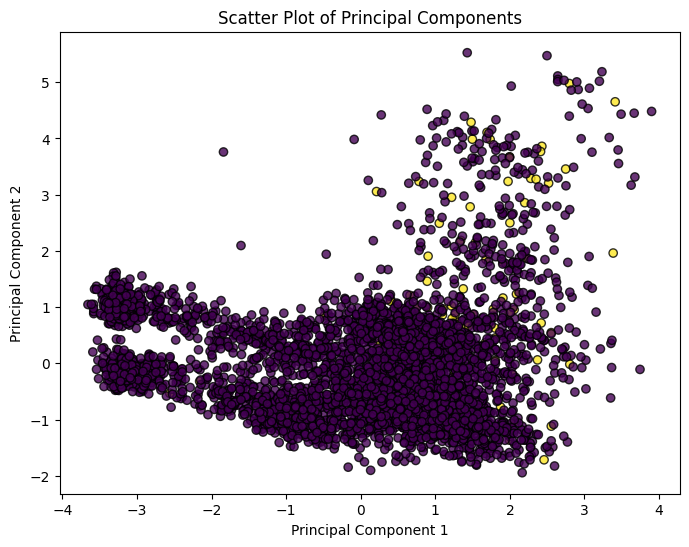

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Assuming 'df' is your DataFrame with features
X = df.drop('stroke', axis=1)  # Exclude the target variable if it's present
y = df['stroke']  # Target variable

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of components (you can adjust this based on explained variance)
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("Cumulative Explained Variance:", cumulative_variance)


# Scatter plot of the principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.8)
plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

